In [3]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary

In [4]:
import os
import numpy as np
import pandas as pd
import torch
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm

### Paths

In [5]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
# figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [6]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SSMfigdir = join(figroot, "SSM_raven")
SiTfigdir = join(figroot, "SiT_raven")

In [7]:
import pandas as pd

# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 100)

In [8]:
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven
!mkdir  {SiTfigdir}


mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven’: File exists


In [111]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_datascale_cmp_curve"

### Util functions for Rule learning dynamics 

Function to parse the experiment string

In [32]:
import re
def extract_and_convert(string):
    """Simple function to extract pattern like stream0_16 or stream16M and convert to float 0.16 or integer 16"""
    # Pattern to match the "0_16" part and convert to float 0.16
    match1 = re.search(r'stream(\d+)_(\d+)', string)
    if match1:
        num1 = str(match1.group(1))
        num2 = str(match1.group(2))
        result = float(f"{num1}.{num2}")
        return result
    
    # Pattern to match the "16M" part and convert to integer 16
    match2 = re.search(r'stream(\d+)M', string)
    if match2:
        result = int(match2.group(1))
        return result
    
    return None

Functions to load the samples and eval stats, plot the data

In [11]:
def sweep_collect_eval_data(expname, exproot, prefix=None):
    assert os.path.exists(join(exproot, expname, "samples")), expname  
    # print(sorted(os.listdir(join(exproot, expname, "samples"))))
    print(f"Extracted data from {join(exproot, expname, 'samples')}")
    print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0])
    # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
    epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if prefix in f])
    eval_col = {}
    for epoch_num in tqdm(epoch_nums):
        samples_eval = torch.load(join(exproot, expname, 'samples', f"{prefix}{epoch_num}.pt"))
        eval_col[epoch_num] = samples_eval
    return eval_col

In [12]:
def extract_rule_list_from_eval_col(eval_col, is_abinit = False):
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        if is_abinit:
            rule_list_all.append(eval_col[epoch]['rule_col_list_abinit'])
            consistency_all.append((eval_col[epoch]['C3_list_abinit'], eval_col[epoch]['C2_list_abinit']))
        else:
            rule_list_all.append(eval_col[epoch]['rule_col_list'])
            consistency_all.append((eval_col[epoch]['C3_list'], eval_col[epoch]['C2_list']))
    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all


def extract_rule_list_from_eval_col_Diffusion(eval_col, ):
    print("diffusion model, just fetch ab init generation")
    epoch_list = sorted(list(eval_col.keys()))
    rule_list_all = []
    consistency_all = []
    for epoch in eval_col.keys():
        rule_list_all.append(eval_col[epoch]['rule_col'])
        consistency_all.append((eval_col[epoch]['c3_list'], eval_col[epoch]['c2_list']))

    rule_list_all = np.array(rule_list_all, dtype=object)
    consistency_all = np.array(consistency_all, dtype=object)
    print(rule_list_all.shape, consistency_all.shape)
    return epoch_list, rule_list_all, consistency_all

In [13]:
def format_rule_list_to_mat(rule_list_all, consistency_all):
    """Format the collected rule_list_all and consistency_all into rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat.
    for plotting purposes.

    Args:
        rule_list_all: np.array, dtype object, shape=(num_epoch, num_sample, 3). 
        consistency_all: np.array, dtype object, shape=(num_epoch, 2, num_sample). 
                    where the 2nd dimension is the consistency of C3 and C2 rules corrspondingly. 

    Returns:
        rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons3_rule_cnt_mat: np.array, shape=(num_epoch, 40). 
        cons2_rule_cnt_mat: np.array, shape=(num_epoch, 40).
    """
    epoch_num = rule_list_all.shape[0]
    rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(rule_list_all[i,:,:].flatten())).astype(int)
        rule_pool_all.append(rule_pool)
    # plot the number of rules == rule_i for each generation
    rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        rule_cnt_mat[i, rule_uniq] = counts

    cons3_rule_pool_all = []
    cons2_rule_pool_all = []
    for i in range(epoch_num): # trange
        rule_pool = np.concatenate(list(consistency_all[i,0,:].flatten())).astype(int)
        cons3_rule_pool_all.append(rule_pool)
        rule_pool = np.concatenate(list(consistency_all[i,1,:].flatten())).astype(int)
        cons2_rule_pool_all.append(rule_pool)

    cons3_rule_cnt_mat = np.zeros((epoch_num, 40))
    cons2_rule_cnt_mat = np.zeros((epoch_num, 40))
    for i in range(epoch_num): # trange
        rule_pool = cons3_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons3_rule_cnt_mat[i, rule_uniq] = counts
        rule_pool = cons2_rule_pool_all[i]
        rule_uniq, counts = np.unique(rule_pool, return_counts=True)
        cons2_rule_cnt_mat[i, rule_uniq] = counts
    return rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat

### Utility functions for plotting

In [14]:
from rule_new_utils import rule_table, relation_dict, attribute_dict
from circuit_toolkit.plot_utils import saveallforms
def visualize_indiv_rule_dynam(epoch_list, rule_mat, conv_wid=10, heldout_id=[1, 16, 20, 34, 37],
                               titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(epoch_list, smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {rule_table[i]}")
        # change the font color of title to red
        if i in heldout_id:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

In [15]:
def visualize_train_heldout_rule(epoch_list, plot_mat, heldout_id, 
                                 normalizer=None, titlestr="", 
                                 reflevel=None):#conv_wid=10, axs=None):
    heldout_mask = np.zeros((40,)).astype(bool)
    heldout_mask[heldout_id] = True
    if normalizer is not None:
        plot_mat = plot_mat / normalizer
    figh, axs = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, ~heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, plot_mat[:, heldout_mask], alpha=0.4)
    plt.plot(epoch_list, plot_mat[:, heldout_mask].mean(axis=1), color='black', linewidth=2)
    if reflevel is not None:
        plt.axhline(y=reflevel, color='r', linestyle='--')
    plt.suptitle(titlestr) # "Accuracy of C3 for each rule type"
    plt.show()
    return figh

### New Plot functions

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data_scaling_curve_syndf(syndf_SiT, mask, huevar="scale", stylevar=None, yvars=("Rules/anyvalid", "Rules/c3"), **kwargs):
    if mask is None:
        mask = slice(None)
    plt.subplots(1, 2, figsize=(9, 4.5))
    plt.subplot(1, 2, 1)
    sns.lineplot(data=syndf_SiT.loc[mask, :], x="dataset_size", y=yvars[0], hue=huevar, marker="o", style=stylevar, **kwargs)
    plt.xscale("log")
    plt.xlabel("dataset size (M)")
    plt.ylabel("Fraction")
    plt.title("valid rows")
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=syndf_SiT.loc[mask, :], x="dataset_size", y=yvars[1], hue=huevar, marker="o", style=stylevar, **kwargs)
    plt.xscale("log")
    plt.xlabel("dataset size (M)")
    plt.ylabel(None)
    plt.title("C3 samples")
    return plt.gcf()

In [192]:
def plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels, xlim=850000):
    """Similar to native function of tensorboad, just plot curve of variables in `varnames` for runs in `runs` with labels in `labels`."""
    figh = plt.figure(figsize=(4 * len(varnames), 4.5))
    
    for i, varname in enumerate(varnames, 1):
        plt.subplot(1, len(varnames), i)
        for runname, label in zip(runs, labels):
            df_run = tb_data_col_DiT[runname]
            plt.plot(df_run[df_run.tag == varname].step, df_run[df_run.tag == varname].value, label=label, alpha=0.5, lw=2)
        
        if i == 1:
            plt.legend()
        plt.xlim(None, xlim)
        plt.xlabel("step")
        plt.title(varname)
    
    return figh

## DiT

In [77]:
tb_data_col_DiT = extract_all_runs(DiT_exproot)

Extracted data from 096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs
Extracted data from 091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs
Extracted data from 085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs
Extracted data from 099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
Extracted data from 087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs
Extracted data from 090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs
Extracted data from 095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs
Extracted data from 086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs
Extracted data from 092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs
Extracted data from 089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorbo

In [78]:
for key in tb_data_col_DiT.keys():
    print(key)
    if tb_data_col_DiT[key]["step"].max() < 999999:
        print(tb_data_col_DiT[key]["step"].max())
        print("unfinished run") 

096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs
091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs
085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs
099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
841900
unfinished run
087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs
090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs
095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs
086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs
092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs
089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs
097-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_20240816-0049/tensorboard_logs
093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs
08

In [79]:
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
syndf_DiT = extract_last_step_summary(tb_data_col_DiT, simplify_runname, ())
# sort by index
syndf_DiT.sort_index(inplace=True)
syndf_DiT

tag                                       Loss/average  Loss/batch  \
run_name                                                             
085-uncond-DiT_S_1-stream0_16M                0.094453    0.089580   
086-uncond-DiT_S_1-stream1_6M                 0.094237    0.098248   
087-uncond-DiT_S_1-stream16M                  0.094620    0.098189   
088-uncond-DiT_S_1-stream16M_heldout0         0.095244    0.096979   
089-uncond-DiT_S_1-stream1_6M_heldout0        0.096174    0.095929   
090-uncond-DiT_S_1-stream0_16M_heldout0       0.095534    0.094757   
091-uncond-DiT_B_1-stream16M                  0.093849    0.094762   
092-uncond-DiT_B_1-stream1_6M                 0.094446    0.092289   
093-uncond-DiT_B_1-stream1_6M_heldout0        0.095623    0.098117   
094-uncond-DiT_B_1-stream0_16M_heldout0       0.093590    0.100504   
095-uncond-DiT_B_1-stream16M_heldout0         0.096062    0.096317   
096-uncond-DiT_B_1-stream0_16M                0.093656    0.089743   
097-uncond-DiT_S_1-stream0_016M               0.039145    0.040616   
098-uncond-DiT_S_1-stream0_016M_heldout0      0.035140    0.037402   
099-uncond-DiT_B_1-stream0_016M               0.023756    0.024797   
100-uncond-DiT_B_1-stream0_016M_heldout0      0.023752    0.021029   

tag                                       Rules/anyvalid  Rules/anyvalid_cnt  \
run_name                                                                       
085-uncond-DiT_S_1-stream0_16M                  0.737956              4534.0   
086-uncond-DiT_S_1-stream1_6M                   0.792806              4871.0   
087-uncond-DiT_S_1-stream16M                    0.780762              4797.0   
088-uncond-DiT_S_1-stream16M_heldout0           0.778483              4783.0   
089-uncond-DiT_S_1-stream1_6M_heldout0          0.765462              4703.0   
090-uncond-DiT_S_1-stream0_16M_heldout0         0.734701              4514.0   
091-uncond-DiT_B_1-stream16M                    0.754069              4633.0   
092-uncond-DiT_B_1-stream1_6M                   0.771810              4742.0   
093-uncond-DiT_B_1-stream1_6M_heldout0          0.798991              4909.0   
094-uncond-DiT_B_1-stream0_16M_heldout0         0.728027              4473.0   
095-uncond-DiT_B_1-stream16M_heldout0           0.756348              4647.0   
096-uncond-DiT_B_1-stream0_16M                  0.756673              4649.0   
097-uncond-DiT_S_1-stream0_016M                 0.433919              2666.0   
098-uncond-DiT_S_1-stream0_016M_heldout0        0.424805              2610.0   
099-uncond-DiT_B_1-stream0_016M                 0.423340              2601.0   
100-uncond-DiT_B_1-stream0_016M_heldout0        0.378418              2325.0   

tag                                       Rules/c2  Rules/c2_cnt  Rules/c3  \
run_name                                                                     
085-uncond-DiT_S_1-stream0_16M            0.111816         229.0  0.595703   
086-uncond-DiT_S_1-stream1_6M             0.117676         241.0  0.650391   
087-uncond-DiT_S_1-stream16M              0.122559         251.0  0.633789   
088-uncond-DiT_S_1-stream16M_heldout0     0.120117         246.0  0.636230   
089-uncond-DiT_S_1-stream1_6M_heldout0    0.125977         258.0  0.608398   
090-uncond-DiT_S_1-stream0_16M_heldout0   0.142090         291.0  0.571289   
091-uncond-DiT_B_1-stream16M              0.125000         256.0  0.603027   
092-uncond-DiT_B_1-stream1_6M             0.107422         220.0  0.643066   
093-uncond-DiT_B_1-stream1_6M_heldout0    0.138672         284.0  0.651855   
094-uncond-DiT_B_1-stream0_16M_heldout0   0.141602         290.0  0.552246   
095-uncond-DiT_B_1-stream16M_heldout0     0.141113         289.0  0.594727   
096-uncond-DiT_B_1-stream0_16M            0.130371         267.0  0.604004   
097-uncond-DiT_S_1-stream0_016M           0.088867         182.0  0.024902   
098-uncond-DiT_S_1-stream0_016M_heldout0  0.062500         128.0  0.002441   
099-uncond-DiT_B_1-stream0_016M           0.071289

In [80]:
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
excluded_runs = [
    "084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200/tensorboard_logs",
    "083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149/tensorboard_logs",
]
syndf_DiT = extract_last_step_summary(tb_data_col_DiT, simplify_runname, excluded_runs)
syndf_DiT.sort_index(inplace=True)
syndf_DiT

tag                                       Loss/average  Loss/batch  \
run_name                                                             
085-uncond-DiT_S_1-stream0_16M                0.094453    0.089580   
086-uncond-DiT_S_1-stream1_6M                 0.094237    0.098248   
087-uncond-DiT_S_1-stream16M                  0.094620    0.098189   
088-uncond-DiT_S_1-stream16M_heldout0         0.095244    0.096979   
089-uncond-DiT_S_1-stream1_6M_heldout0        0.096174    0.095929   
090-uncond-DiT_S_1-stream0_16M_heldout0       0.095534    0.094757   
091-uncond-DiT_B_1-stream16M                  0.093849    0.094762   
092-uncond-DiT_B_1-stream1_6M                 0.094446    0.092289   
093-uncond-DiT_B_1-stream1_6M_heldout0        0.095623    0.098117   
094-uncond-DiT_B_1-stream0_16M_heldout0       0.093590    0.100504   
095-uncond-DiT_B_1-stream16M_heldout0         0.096062    0.096317   
096-uncond-DiT_B_1-stream0_16M                0.093656    0.089743   
097-uncond-DiT_S_1-stream0_016M               0.039145    0.040616   
098-uncond-DiT_S_1-stream0_016M_heldout0      0.035140    0.037402   
099-uncond-DiT_B_1-stream0_016M               0.023756    0.024797   
100-uncond-DiT_B_1-stream0_016M_heldout0      0.023752    0.021029   

tag                                       Rules/anyvalid  Rules/anyvalid_cnt  \
run_name                                                                       
085-uncond-DiT_S_1-stream0_16M                  0.737956              4534.0   
086-uncond-DiT_S_1-stream1_6M                   0.792806              4871.0   
087-uncond-DiT_S_1-stream16M                    0.780762              4797.0   
088-uncond-DiT_S_1-stream16M_heldout0           0.778483              4783.0   
089-uncond-DiT_S_1-stream1_6M_heldout0          0.765462              4703.0   
090-uncond-DiT_S_1-stream0_16M_heldout0         0.734701              4514.0   
091-uncond-DiT_B_1-stream16M                    0.754069              4633.0   
092-uncond-DiT_B_1-stream1_6M                   0.771810              4742.0   
093-uncond-DiT_B_1-stream1_6M_heldout0          0.798991              4909.0   
094-uncond-DiT_B_1-stream0_16M_heldout0         0.728027              4473.0   
095-uncond-DiT_B_1-stream16M_heldout0           0.756348              4647.0   
096-uncond-DiT_B_1-stream0_16M                  0.756673              4649.0   
097-uncond-DiT_S_1-stream0_016M                 0.433919              2666.0   
098-uncond-DiT_S_1-stream0_016M_heldout0        0.424805              2610.0   
099-uncond-DiT_B_1-stream0_016M                 0.423340              2601.0   
100-uncond-DiT_B_1-stream0_016M_heldout0        0.378418              2325.0   

tag                                       Rules/c2  Rules/c2_cnt  Rules/c3  \
run_name                                                                     
085-uncond-DiT_S_1-stream0_16M            0.111816         229.0  0.595703   
086-uncond-DiT_S_1-stream1_6M             0.117676         241.0  0.650391   
087-uncond-DiT_S_1-stream16M              0.122559         251.0  0.633789   
088-uncond-DiT_S_1-stream16M_heldout0     0.120117         246.0  0.636230   
089-uncond-DiT_S_1-stream1_6M_heldout0    0.125977         258.0  0.608398   
090-uncond-DiT_S_1-stream0_16M_heldout0   0.142090         291.0  0.571289   
091-uncond-DiT_B_1-stream16M              0.125000         256.0  0.603027   
092-uncond-DiT_B_1-stream1_6M             0.107422         220.0  0.643066   
093-uncond-DiT_B_1-stream1_6M_heldout0    0.138672         284.0  0.651855   
094-uncond-DiT_B_1-stream0_16M_heldout0   0.141602         290.0  0.552246   
095-uncond-DiT_B_1-stream16M_heldout0     0.141113         289.0  0.594727   
096-uncond-DiT_B_1-stream0_16M            0.130371         267.0  0.604004   
097-uncond-DiT_S_1-stream0_016M           0.088867         182.0  0.024902   
098-uncond-DiT_S_1-stream0_016M_heldout0  0.062500         128.0  0.002441   
099-uncond-DiT_B_1-stream0_016M           0.071289

### Plot Scaling curve

In [81]:
syndf_DiT.to_csv(join(tabdir, "DiT_raven_tensorboard_data.csv"))
pkl.dump(tb_data_col_DiT, open(join(tabdir, "DiT_raven_tensorboard_raw_data.pkl"), "wb"))

In [112]:
syndf_DiT = pd.read_csv(join(tabdir, "DiT_raven_tensorboard_data.csv"), index_col=0)
tb_data_col_DiT = pkl.load(open(join(tabdir, "DiT_raven_tensorboard_raw_data.pkl"), "rb"))

In [113]:
syndf_DiT["dataset_size"] = syndf_DiT.index.map(extract_and_convert)
syndf_DiT["heldout"] = syndf_DiT.index.map(lambda x: "_heldout0" in x)
syndf_DiT["scale"] = syndf_DiT.index.map(lambda x: "DiT_B_1" if "DiT_B_1" in x else "DiT_S_1" if "DiT_S_1" in x else None)

In [114]:
syndf_DiT

Loss/average  Loss/batch  \
run_name                                                             
085-uncond-DiT_S_1-stream0_16M                0.094453    0.089580   
086-uncond-DiT_S_1-stream1_6M                 0.094237    0.098248   
087-uncond-DiT_S_1-stream16M                  0.094620    0.098189   
088-uncond-DiT_S_1-stream16M_heldout0         0.095244    0.096979   
089-uncond-DiT_S_1-stream1_6M_heldout0        0.096174    0.095929   
090-uncond-DiT_S_1-stream0_16M_heldout0       0.095534    0.094757   
091-uncond-DiT_B_1-stream16M                  0.093849    0.094762   
092-uncond-DiT_B_1-stream1_6M                 0.094446    0.092289   
093-uncond-DiT_B_1-stream1_6M_heldout0        0.095623    0.098117   
094-uncond-DiT_B_1-stream0_16M_heldout0       0.093590    0.100504   
095-uncond-DiT_B_1-stream16M_heldout0         0.096062    0.096317   
096-uncond-DiT_B_1-stream0_16M                0.093656    0.089743   
097-uncond-DiT_S_1-stream0_016M               0.039145    0.040616   
098-uncond-DiT_S_1-stream0_016M_heldout0      0.035140    0.037402   
099-uncond-DiT_B_1-stream0_016M               0.023756    0.024797   
100-uncond-DiT_B_1-stream0_016M_heldout0      0.023752    0.021029   

                                          Rules/anyvalid  Rules/anyvalid_cnt  \
run_name                                                                       
085-uncond-DiT_S_1-stream0_16M                  0.737956              4534.0   
086-uncond-DiT_S_1-stream1_6M                   0.792806              4871.0   
087-uncond-DiT_S_1-stream16M                    0.780762              4797.0   
088-uncond-DiT_S_1-stream16M_heldout0           0.778483              4783.0   
089-uncond-DiT_S_1-stream1_6M_heldout0          0.765462              4703.0   
090-uncond-DiT_S_1-stream0_16M_heldout0         0.734701              4514.0   
091-uncond-DiT_B_1-stream16M                    0.754069              4633.0   
092-uncond-DiT_B_1-stream1_6M                   0.771810              4742.0   
093-uncond-DiT_B_1-stream1_6M_heldout0          0.798991              4909.0   
094-uncond-DiT_B_1-stream0_16M_heldout0         0.728027              4473.0   
095-uncond-DiT_B_1-stream16M_heldout0           0.756348              4647.0   
096-uncond-DiT_B_1-stream0_16M                  0.756673              4649.0   
097-uncond-DiT_S_1-stream0_016M                 0.433919              2666.0   
098-uncond-DiT_S_1-stream0_016M_heldout0        0.424805              2610.0   
099-uncond-DiT_B_1-stream0_016M                 0.423340              2601.0   
100-uncond-DiT_B_1-stream0_016M_heldout0        0.378418              2325.0   

                                          Rules/c2  Rules/c2_cnt  Rules/c3  \
run_name                                                                     
085-uncond-DiT_S_1-stream0_16M            0.111816         229.0  0.595703   
086-uncond-DiT_S_1-stream1_6M             0.117676         241.0  0.650391   
087-uncond-DiT_S_1-stream16M              0.122559         251.0  0.633789   
088-uncond-DiT_S_1-stream16M_heldout0     0.120117         246.0  0.636230   
089-uncond-DiT_S_1-stream1_6M_heldout0    0.125977         258.0  0.608398   
090-uncond-DiT_S_1-stream0_16M_heldout0   0.142090         291.0  0.571289   
091-uncond-DiT_B_1-stream16M              0.125000         256.0  0.603027   
092-uncond-DiT_B_1-stream1_6M             0.107422         220.0  0.643066   
093-uncond-DiT_B_1-stream1_6M_heldout0    0.138672         284.0  0.651855   
094-uncond-DiT_B_1-stream0_16M_heldout0   0.141602         290.0  0.552246   
095-uncond-DiT_B_1-stream16M_heldout0     0.141113         289.0  0.594727   
096-uncond-DiT_B_1-stream0_16M            0.130371         267.0  0.604004   
097-uncond-DiT_S_1-stream0_016M           0.088867         182.0  0.024902   
098-uncond-DiT_S_1-stream0_016M_heldout0  0.062500         128.0  0.002441   
099-uncond-DiT_B_1-stream0_016M           0.071289         146.0  0.019043   
100-uncond-DiT

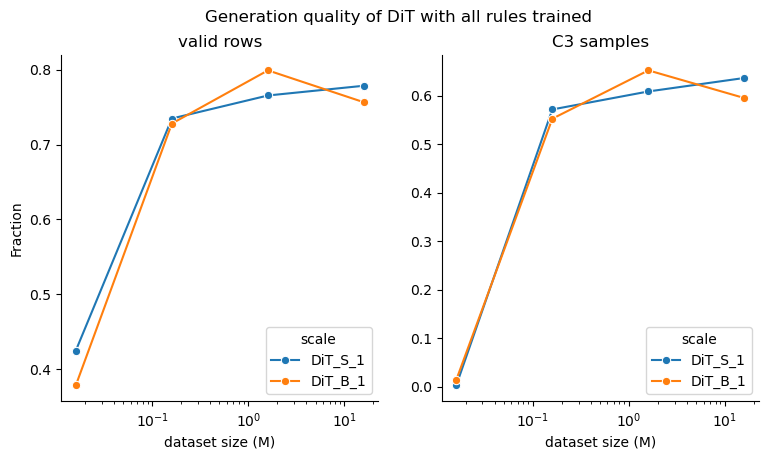

In [115]:
figh = plot_data_scaling_curve_syndf(syndf_DiT, syndf_DiT.heldout==True)
plt.suptitle("Generation quality of DiT with all rules trained")
saveallforms(figdir, "DiT_heldout_data_model_scale_cmp_curve", figh)

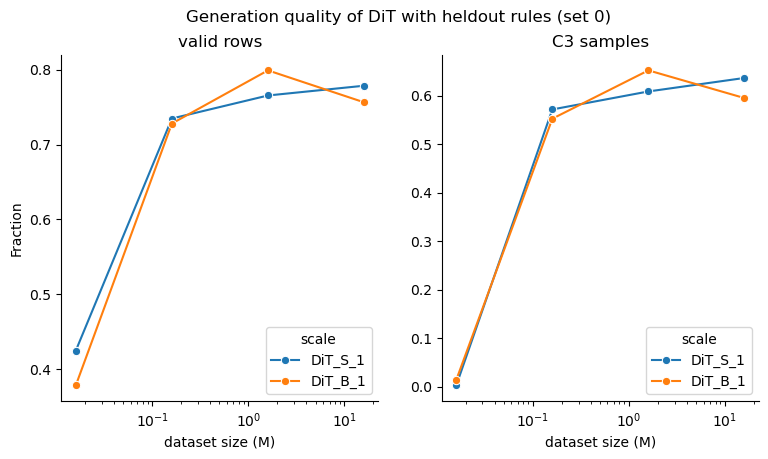

In [116]:
figh = plot_data_scaling_curve_syndf(syndf_DiT, syndf_DiT.heldout==True)
plt.suptitle("Generation quality of DiT with heldout rules (set 0)")
saveallforms(figdir, "DiT_heldout0_data_model_scale_cmp_curve", figh)

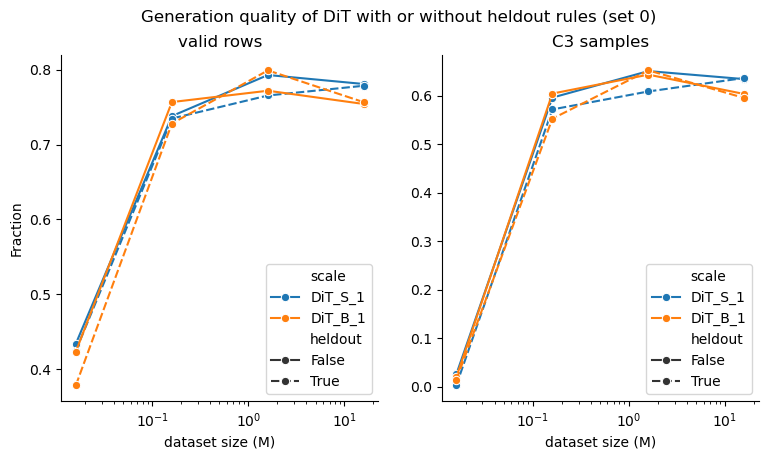

In [117]:
figh = plot_data_scaling_curve_syndf(syndf_DiT, None, stylevar="heldout", huevar="scale")
plt.suptitle("Generation quality of DiT with or without heldout rules (set 0)")
saveallforms(figdir, "DiT_both_data_model_scale_heldout_cmp_curve", figh)

### Plot Learning curve cmp

In [210]:
# filter `syndf_DiT` to only include run_name with DiT_B_1 in it and heldout0, 
syndf_DiT.loc[syndf_DiT.full_name.str.contains("DiT_B_1") & syndf_DiT.full_name.str.contains("heldout0"), :].full_name.to_list()+\
syndf_DiT.loc[syndf_DiT.full_name.str.contains("DiT_S_1") & syndf_DiT.full_name.str.contains("heldout0"), :].full_name.to_list()

['093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
 '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
 '095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
 '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs',
 '088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs',
 '089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs',
 '090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs',
 '098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs']

In [216]:
# filter `syndf_DiT` to only include run_name with DiT_B_1 in it and heldout0, 
syndf_DiT.loc[syndf_DiT.full_name.str.contains("DiT_B_1") & ~syndf_DiT.full_name.str.contains("heldout0"), :].full_name.to_list()+\
syndf_DiT.loc[syndf_DiT.full_name.str.contains("DiT_S_1") & ~syndf_DiT.full_name.str.contains("heldout0"), :].full_name.to_list()

['091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs',
 '092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs',
 '096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs',
 '099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs',
 '085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs',
 '086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs',
 '087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs',
 '097-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_20240816-0049/tensorboard_logs']

In [ ]:
df_run.tag.unique()

array(['Rules/c3_cnt', 'Rules/c2_cnt', 'Rules/anyvalid_cnt', 'Rules/c3',
       'Rules/c2', 'Rules/anyvalid', 'Loss/average', 'Loss/batch',
       'Speed/steps_per_sec'], dtype=object)

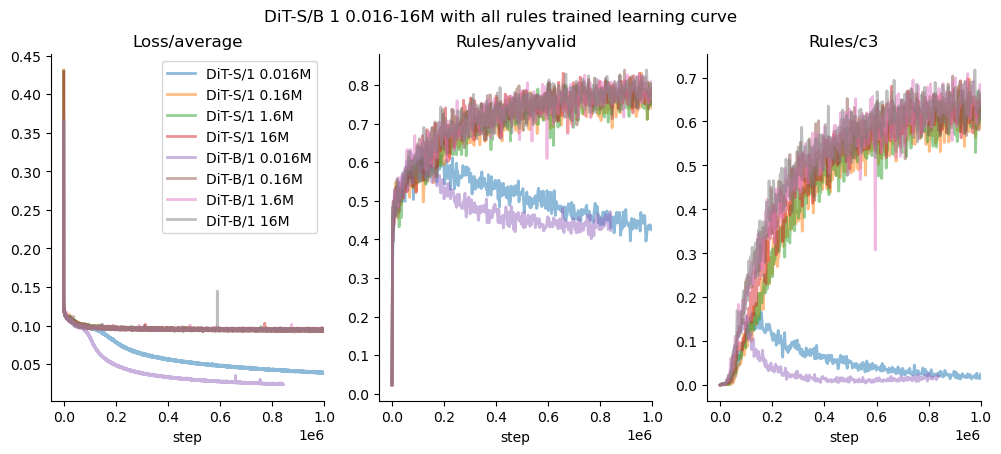

In [217]:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        '097-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_20240816-0049/tensorboard_logs',
        '085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs',
        '086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs',
        '087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs',
        '099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs',
        '096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs',
        '092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs',
        '091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs',
        ]
labels = ["DiT-S/1 0.016M", 
          "DiT-S/1 0.16M", 
          "DiT-S/1 1.6M",
          "DiT-S/1 16M",
          "DiT-B/1 0.016M",
          "DiT-B/1 0.16M",
          "DiT-B/1 1.6M",
          "DiT-B/1 16M",
        ]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("DiT-S/B 1 0.016-16M with all rules trained learning curve")
saveallforms(figdir, "DiT-S-B_1_0.016-16M_all_data_learning_curve", figh)

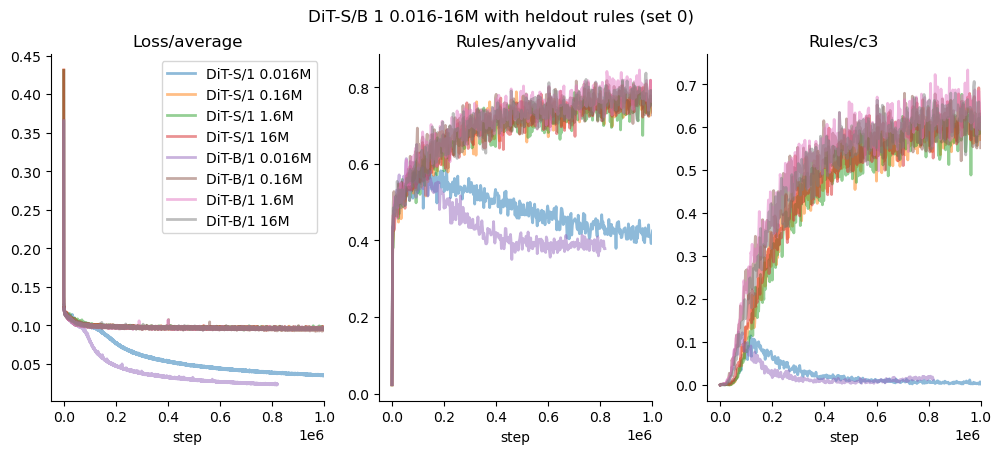

In [218]:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        '098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs',
        '090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs',
        '089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs',
        '088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs',
        '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs',
        '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
        '093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
        '095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
        ]
labels = ["DiT-S/1 0.016M", 
          "DiT-S/1 0.16M", 
          "DiT-S/1 1.6M",
          "DiT-S/1 16M",
          "DiT-B/1 0.016M",
          "DiT-B/1 0.16M",
          "DiT-B/1 1.6M",
          "DiT-B/1 16M",
        ]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("DiT-S/B 1 0.016-16M with heldout rules (set 0)")
saveallforms(figdir, "DiT-S-B_1_0.016-16M_heldout0_learning_curve", figh)

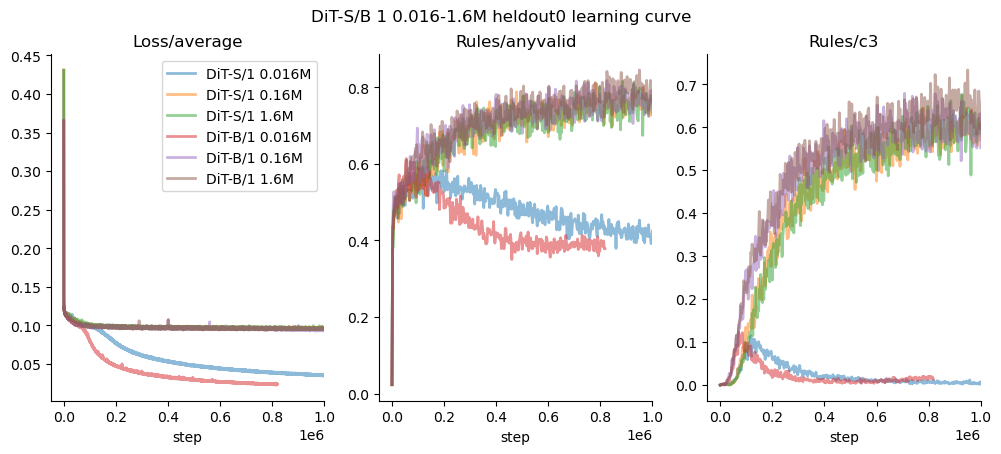

In [214]:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        '098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs',
        '090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs',
        '089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs',
        # '088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs',
        '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs',
        '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
        '093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
        # '095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
        ]
labels = ["DiT-S/1 0.016M", 
          "DiT-S/1 0.16M", 
          "DiT-S/1 1.6M",
        #   "DiT-S/1 16M",
          "DiT-B/1 0.016M",
          "DiT-B/1 0.16M",
          "DiT-B/1 1.6M",
        #   "DiT-B/1 16M",
        ]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("DiT-S/B 1 0.016-1.6M with heldout rules (set 0)")
saveallforms(figdir, "DiT-S-B_1_0.016-1.6M_heldout0_learning_curve", figh)

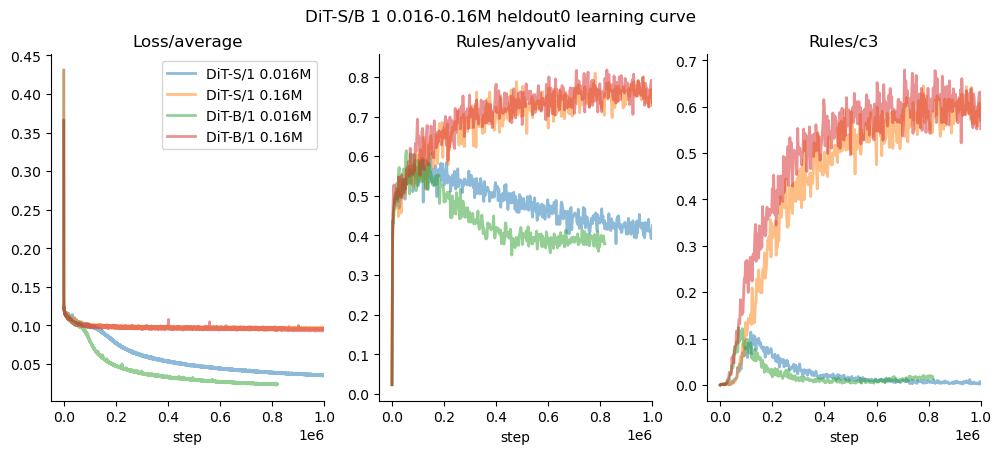

In [215]:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        '098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs',
        '090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs',
        # '089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs',
        # '088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs',
        '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs',
        '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
        # '093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
        # '095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
        ]
labels = ["DiT-S/1 0.016M", 
          "DiT-S/1 0.16M", 
        #   "DiT-S/1 1.6M",
        #   "DiT-S/1 16M",
          "DiT-B/1 0.016M",
          "DiT-B/1 0.16M",
        #   "DiT-B/1 1.6M",
        #   "DiT-B/1 16M",
        ]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("DiT-S/B 1 0.016-0.16M heldout0 learning curve")
saveallforms(figdir, "DiT-S-B_1_0.016-0.16M_heldout0_learning_curve", figh)

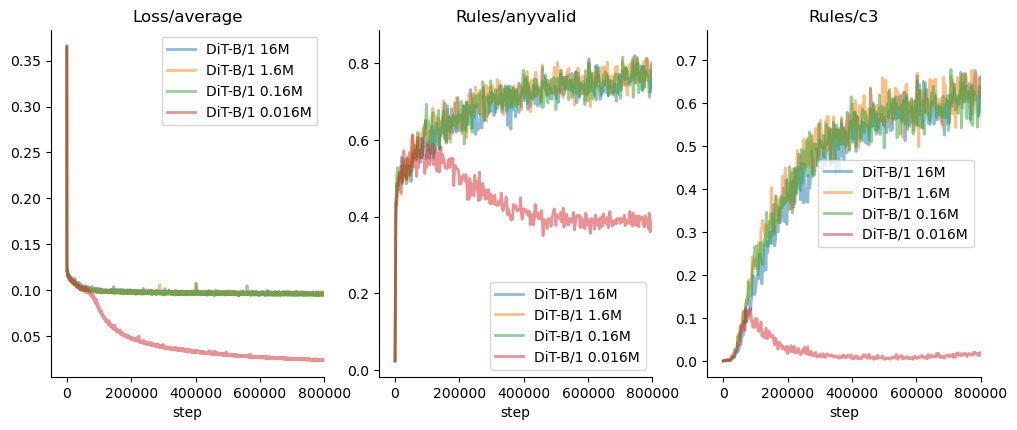

In [118]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = ['095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
        '093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
        '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
        '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs']
labels = ["DiT-B/1 16M",
          "DiT-B/1 1.6M",
          "DiT-B/1 0.16M", 
          "DiT-B/1 0.016M"]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels, xlim=8E5);
saveallforms(figdir, "DiT_B_1_16M_0.016M_cmp_curve", figh)

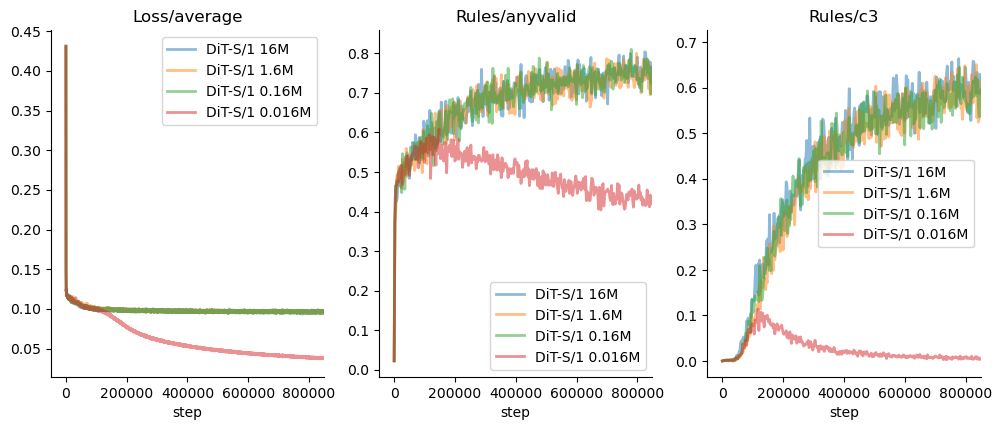

In [119]:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = ["088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs",
        "089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs",
        "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs",
        "098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs",]
labels = ["DiT-S/1 16M",
          "DiT-S/1 1.6M",
          "DiT-S/1 0.16M", 
          "DiT-S/1 0.016M"]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels,)
saveallforms(figdir, "DiT_S_1_16M_0.016M_cmp_curve", figh)

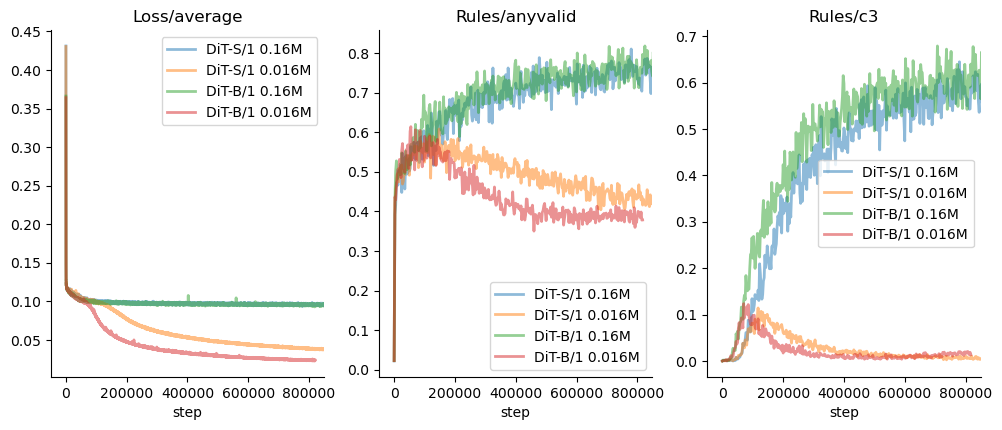

In [120]:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [#"088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs",
        #"089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs",
        "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs",
        "098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs",
        #'095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
        #'093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
        '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
        '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs',
        ]
labels = [#"DiT-S/1 16M",
          #"DiT-S/1 1.6M",
          "DiT-S/1 0.16M", 
          "DiT-S/1 0.016M",
          #"DiT-B/1 16M",
          #"DiT-B/1 1.6M",
          "DiT-B/1 0.16M", 
          "DiT-B/1 0.016M"]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels,)
saveallforms(figdir, "DiT_S+B_0.16M_0.016M_cmp_curve", figh)

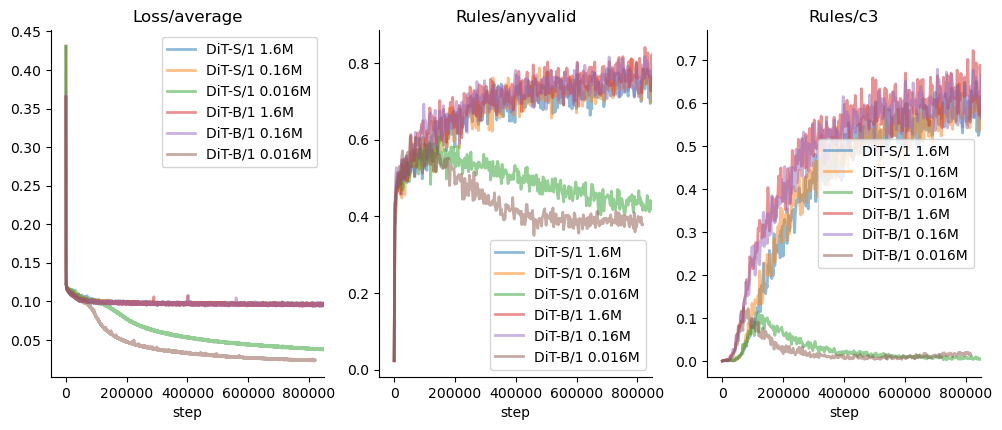

In [121]:

varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [#"088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs",
        "089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs",
        "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs",
        "098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs",
        #'095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
        '093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
        '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
        '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs',
        ]
labels = [#"DiT-S/1 16M",
          "DiT-S/1 1.6M",
          "DiT-S/1 0.16M", 
          "DiT-S/1 0.016M",
          #"DiT-B/1 16M",
          "DiT-B/1 1.6M",
          "DiT-B/1 0.16M", 
          "DiT-B/1 0.016M"]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels,)
saveallforms(figdir, "DiT_S+B_1.6M_0.16M_0.016M_cmp_curve", figh)

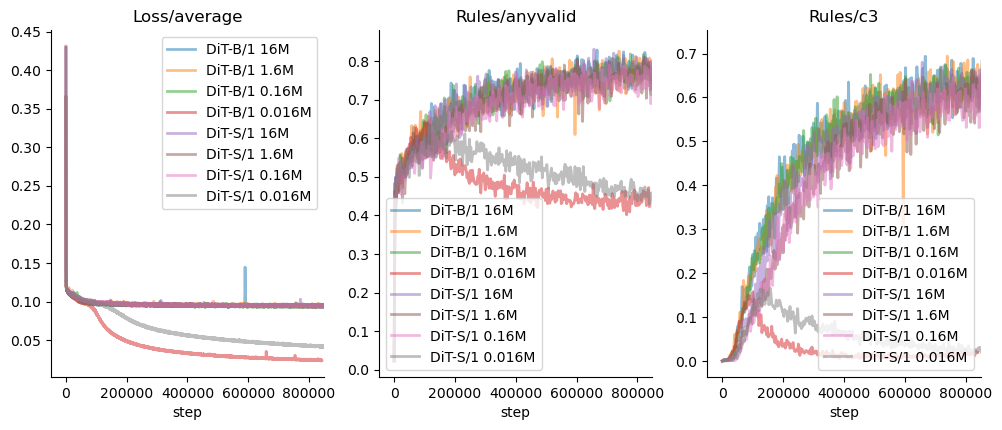

In [122]:
runs = ['091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs',
 '092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs',
 '096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs',
 '099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs',
 '087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs',
 '086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs',
 '085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs',
 '097-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_20240816-0049/tensorboard_logs']
labels = ["DiT-B/1 16M",
            "DiT-B/1 1.6M",
            "DiT-B/1 0.16M", 
            "DiT-B/1 0.016M",
            "DiT-S/1 16M",
            "DiT-S/1 1.6M",
            "DiT-S/1 0.16M", 
            "DiT-S/1 0.016M"]
figh = plot_learning_curve_cmp(tb_data_col_DiT, varnames, runs, labels,)
figh.suptitle("DiT-S/B all classes")
saveallforms(figdir, "DiT_S+B_all_cmp_curve", figh)

### Scratch space

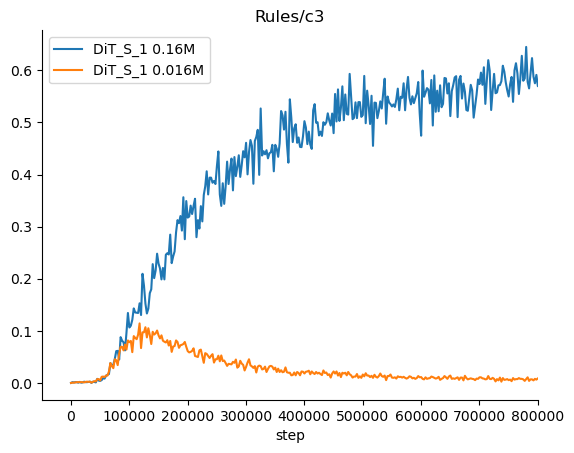

In [ ]:
varname = "Rules/c3"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label)
plt.legend()
plt.xlim(None, 800000)
plt.xlabel("step")
plt.title(varname)
plt.show()

['085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs',
 '086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs',
 '087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs',
 '097-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_20240816-0049/tensorboard_logs']

In [ ]:
runs = ["088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs",
        "089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs",
        "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs",
        "098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050/tensorboard_logs",]
labels = ["DiT-S/1 16M",
          "DiT-S/1 1.6M",
          "DiT-S/1 0.16M", 
          "DiT-S/1 0.016M"]

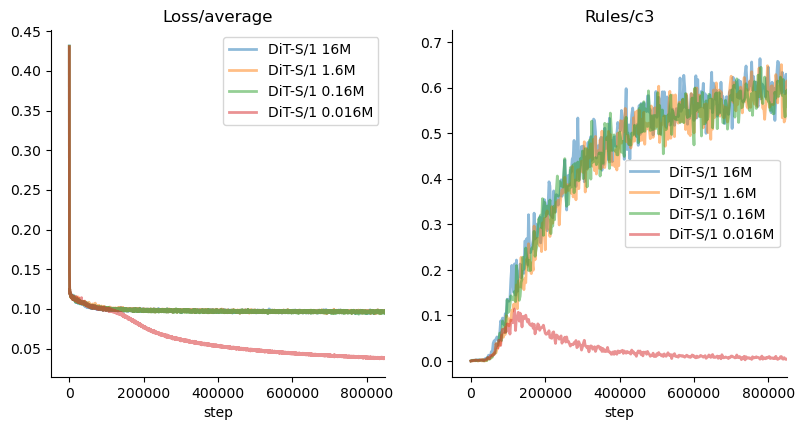

In [ ]:
plt.figure(figsize=(9.5, 4.5))
plt.subplot(1, 2, 1)
varname = "Loss/average"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label, alpha=0.5, lw=2)
plt.legend()
plt.xlim(None, 850000)
plt.xlabel("step")
plt.title(varname)
plt.subplot(1, 2, 2)
varname = "Rules/c3"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label, alpha=0.5, lw=2)
plt.legend()
plt.xlim(None, 850000)
plt.xlabel("step")
plt.title(varname)
saveallforms(figdir, "DiT_S_1_16M_0.016M_cmp_curve")
# saveallforms(figdir, "DiT_S_1_0.16M_0.016M_cmp_curve")
plt.show()

In [ ]:
runs = ['095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs',
        '093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs',
        '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs',
        '100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs']
labels = ["DiT-B/1 16M",
          "DiT-B/1 1.6M",
          "DiT-B/1 0.16M", 
          "DiT-B/1 0.016M"]

In [ ]:
plt.figure(figsize=(9.5, 4.5))
plt.subplot(1, 2, 1)
varname = "Loss/average"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label, alpha=0.5, lw=2)
plt.legend()
plt.xlim(None, 850000)
plt.xlabel("step")
plt.title(varname)
plt.subplot(1, 2, 2)
varname = "Rules/c3"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label, alpha=0.5, lw=2)
plt.legend()
plt.xlim(None, 850000)
plt.xlabel("step")
plt.title(varname)
saveallforms(figdir, "DiT_B_1_16M_0.016M_cmp_curve")
plt.show()

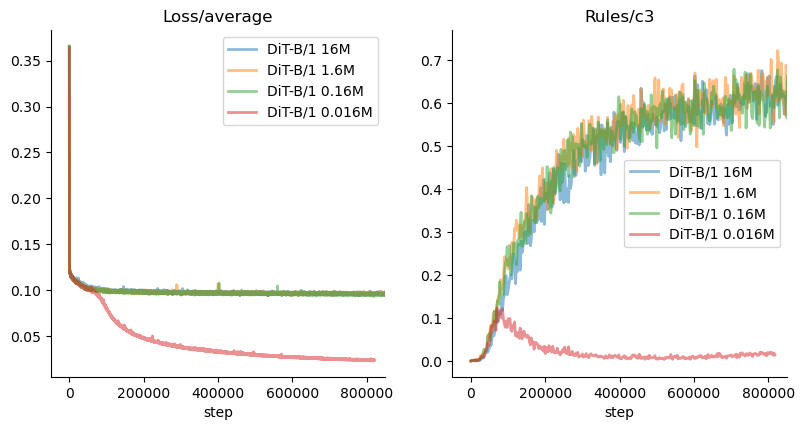

In [34]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_datascale_cmp_curve"
plt.figure(figsize=(9.5, 4.5))
plt.subplot(1, 2, 1)
varname = "Loss/average"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label, alpha=0.5, lw=2)
plt.legend()
plt.xlim(None, 850000)
plt.xlabel("step")
plt.title(varname)
plt.subplot(1, 2, 2)
varname = "Rules/c3"
for runname, label in zip(runs, labels):
    tb_data_col_DiT[runname]
    df_run = tb_data_col_DiT[runname]
    plt.plot(df_run[df_run.tag==varname].step, df_run[df_run.tag==varname].value, label=label, alpha=0.5, lw=2)
plt.legend()
plt.xlim(None, 850000)
plt.xlabel("step")
plt.title(varname)
saveallforms(figdir, "DiT_B_1_16M_0.016M_cmp_curve")
plt.show()

## SiT

In [18]:
tb_data_col_SiT = extract_all_runs(SiT_exproot)

Extracted data from 017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
Extracted data from 013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 016-SiT_B_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 008

In [19]:
for key in tb_data_col_SiT.keys():
    print(key)
    if tb_data_col_SiT[key]["step"].max() < 999999:
        print(tb_data_col_SiT[key]["step"].max())
        print("unfinished run") 

017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
875000
unfinished run
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs
006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs
012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
815200
unfinished run
007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs
016-SiT_B_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs
008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
975000
unfinished run
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-N

In [20]:
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
syndf_SiT = extract_last_step_summary(tb_data_col_SiT, simplify_runname, ())
# sort by index
syndf_SiT.sort_index(inplace=True)
syndf_SiT

tag                                                     Loss/average  \
run_name                                                               
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None          0.792924   
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None          0.788350   
006-SiT_S_1-stream0_016M_all-Linear-velocity-None           0.513552   
007-SiT_S_1-stream0_16M_all-Linear-velocity-None            0.792181   
008-SiT_S_1-stream1_6M_all-Linear-velocity-None             0.796287   
010-SiT_S_1-stream16M_all-Linear-velocity-None              0.796884   
011-SiT_B_1-stream0_16M_all-Linear-velocity-None            0.781162   
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None         0.804236   
012-SiT_B_1-stream0_016M_all-Linear-velocity-None           0.436349   
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None        0.801265   
013-SiT_B_1-stream16M_all-Linear-velocity-None              0.794365   
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None      0.494431   
014-SiT_B_1-stream1_6M_all-Linear-velocity-None             0.794140   
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None       0.800243   
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None      0.412909   
016-SiT_B_1-stream16M_heldout0-Linear-velocity-None         0.801500   
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None       0.775788   
018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None        0.801182   

tag                                                     Loss/batch  \
run_name                                                             
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None        0.794975   
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None        0.783931   
006-SiT_S_1-stream0_016M_all-Linear-velocity-None         0.468938   
007-SiT_S_1-stream0_16M_all-Linear-velocity-None          0.792535   
008-SiT_S_1-stream1_6M_all-Linear-velocity-None           0.785929   
010-SiT_S_1-stream16M_all-Linear-velocity-None            0.830317   
011-SiT_B_1-stream0_16M_all-Linear-velocity-None          0.752783   
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None       0.827832   
012-SiT_B_1-stream0_016M_all-Linear-velocity-None         0.419030   
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None      0.809084   
013-SiT_B_1-stream16M_all-Linear-velocity-None            0.773824   
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None    0.532683   
014-SiT_B_1-stream1_6M_all-Linear-velocity-None           0.779815   
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None     0.843793   
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None    0.375841   
016-SiT_B_1-stream16M_heldout0-Linear-velocity-None       0.741092   
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None     0.780011   
018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None      0.803040   

tag                                                     Rules/anyvalid  \
run_name                                                                 
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None            0.840983   
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None            0.810059   
006-SiT_S_1-stream0_016M_all-Linear-velocity-None             0.499837   
007-SiT_S_1-stream0_16M_all-Linear-velocity-None              0.846842   
008-SiT_S_1-stream1_6M_all-Linear-velocity-None               0.885417   
010-SiT_S_1-stream16M_all-Linear-velocity-None                0.875488   
011-SiT_B_1-stream0_16M_all-Linear-velocity-None              0.797852   
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None           0.870117   
012-SiT_B_1-stream0_016M_all-Linear-velocity-None             0.471517   
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None          0.886393   
013-SiT_B_1-stream16M_all-Linear-velocity-None                0.892090   
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None        0.456868   
014-SiT_B_1-stream1_6M_all-Linear-velocity-None               0.875000   
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity

In [21]:
syndf_SiT.to_csv(join(tabdir, "SiT_raven_tensorboard_data.csv"))
pkl.dump(tb_data_col_SiT, open(join(tabdir, "SiT_raven_tensorboard_raw_data.pkl"), "wb"))

In [123]:
syndf_SiT = pd.read_csv(join(tabdir, "SiT_raven_tensorboard_data.csv"), index_col=0)
tb_data_col_SiT = pkl.load(open(join(tabdir, "SiT_raven_tensorboard_raw_data.pkl"), "rb"))

In [124]:
syndf_SiT["dataset_size"] = syndf_SiT.index.map(extract_and_convert)
syndf_SiT["heldout"] = syndf_SiT.index.map(lambda x: "_heldout0" in x)
syndf_SiT["scale"] = syndf_SiT.index.map(lambda x: "SiT_B_1" if "SiT_B_1" in x else "SiT_S_1" if "SiT_S_1" in x else None)

In [125]:
syndf_SiT

Loss/average  \
run_name                                                               
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None          0.792924   
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None          0.788350   
006-SiT_S_1-stream0_016M_all-Linear-velocity-None           0.513552   
007-SiT_S_1-stream0_16M_all-Linear-velocity-None            0.792181   
008-SiT_S_1-stream1_6M_all-Linear-velocity-None             0.796287   
010-SiT_S_1-stream16M_all-Linear-velocity-None              0.796884   
011-SiT_B_1-stream0_16M_all-Linear-velocity-None            0.781162   
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None         0.804236   
012-SiT_B_1-stream0_016M_all-Linear-velocity-None           0.436349   
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None        0.801265   
013-SiT_B_1-stream16M_all-Linear-velocity-None              0.794365   
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None      0.494431   
014-SiT_B_1-stream1_6M_all-Linear-velocity-None             0.794140   
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None       0.800243   
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None      0.412909   
016-SiT_B_1-stream16M_heldout0-Linear-velocity-None         0.801500   
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None       0.775788   
018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None        0.801182   

                                                        Loss/batch  \
run_name                                                             
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None        0.794975   
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None        0.783931   
006-SiT_S_1-stream0_016M_all-Linear-velocity-None         0.468938   
007-SiT_S_1-stream0_16M_all-Linear-velocity-None          0.792535   
008-SiT_S_1-stream1_6M_all-Linear-velocity-None           0.785929   
010-SiT_S_1-stream16M_all-Linear-velocity-None            0.830317   
011-SiT_B_1-stream0_16M_all-Linear-velocity-None          0.752783   
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None       0.827832   
012-SiT_B_1-stream0_016M_all-Linear-velocity-None         0.419030   
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None      0.809084   
013-SiT_B_1-stream16M_all-Linear-velocity-None            0.773824   
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None    0.532683   
014-SiT_B_1-stream1_6M_all-Linear-velocity-None           0.779815   
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None     0.843793   
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None    0.375841   
016-SiT_B_1-stream16M_heldout0-Linear-velocity-None       0.741092   
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None     0.780011   
018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None      0.803040   

                                                        Rules/anyvalid  \
run_name                                                                 
004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None            0.840983   
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None            0.810059   
006-SiT_S_1-stream0_016M_all-Linear-velocity-None             0.499837   
007-SiT_S_1-stream0_16M_all-Linear-velocity-None              0.846842   
008-SiT_S_1-stream1_6M_all-Linear-velocity-None               0.885417   
010-SiT_S_1-stream16M_all-Linear-velocity-None                0.875488   
011-SiT_B_1-stream0_16M_all-Linear-velocity-None              0.797852   
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None           0.870117   
012-SiT_B_1-stream0_016M_all-Linear-velocity-None             0.471517   
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None          0.886393   
013-SiT_B_1-stream16M_all-Linear-velocity-None                0.892090   
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None        0.456868   
014-SiT_B_1-stream1_6M_all-Linear-velocity-None               0.875000   
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None         0.845378   
015-SiT_B_1-stream0_016M_heldo

In [35]:
syndf_SiT.dataset_size.unique()

array([ 0.16 ,  0.016,  1.6  , 16.   ])

### Plot Scaling curve

In [130]:
exclude_msk = (~ syndf_SiT.index.str.contains("pilot") )

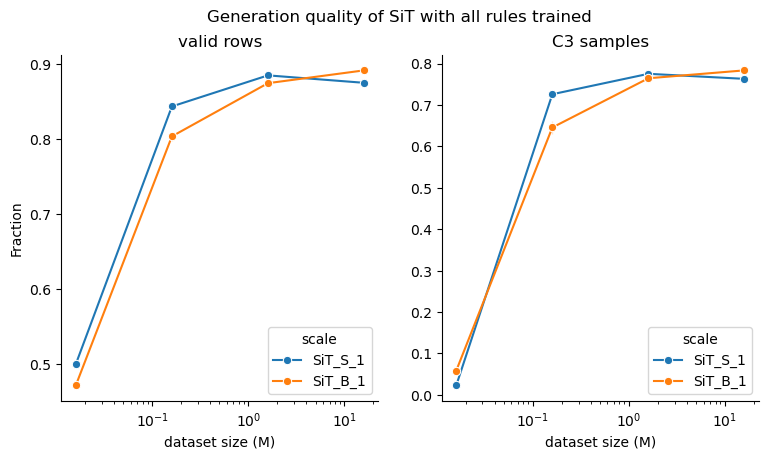

In [134]:
figh = plot_data_scaling_curve_syndf(syndf_SiT, syndf_SiT.heldout==False & exclude_msk)
plt.suptitle("Generation quality of SiT with all rules trained")
saveallforms(figdir, "SiT_all_data_model_scale_cmp_curve", figh)

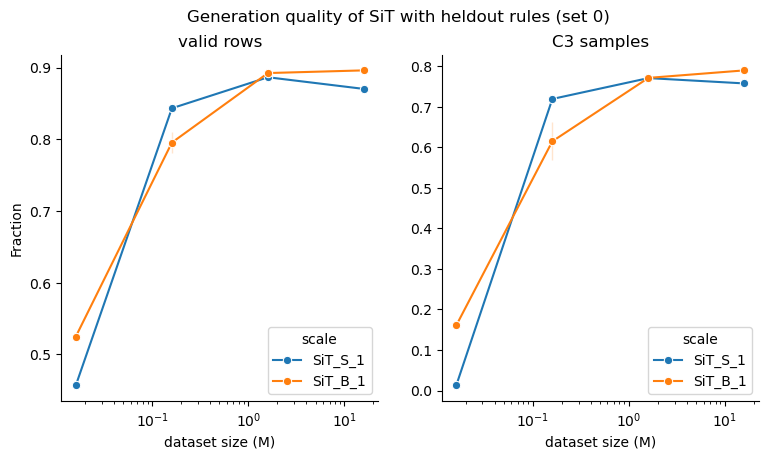

In [135]:
figh = plot_data_scaling_curve_syndf(syndf_SiT, syndf_SiT.heldout==True& exclude_msk)
plt.suptitle("Generation quality of SiT with heldout rules (set 0)")
saveallforms(figdir, "SiT_heldout0_data_model_scale_cmp_curve", figh)

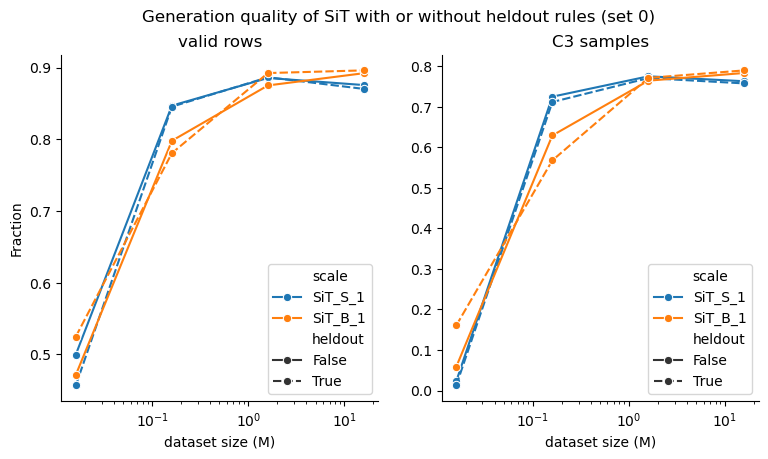

In [136]:
figh = plot_data_scaling_curve_syndf(syndf_SiT, exclude_msk, stylevar="heldout", huevar="scale")
plt.suptitle("Generation quality of SiT with or without heldout rules (set 0)")
saveallforms(figdir, "SiT_both_data_model_scale_heldout_cmp_curve", figh)

### Plot Learning curve cmp

In [201]:
sorted(syndf_SiT.loc[syndf_SiT.heldout==True & exclude_msk, :].full_name.to_list())

['004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
 '005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
 '011-SiT_S_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs',
 '012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs',
 '013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs',
 '014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs',
 '015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs',
 '016-SiT_B_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs',
 '017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs',
 '018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs']

In [207]:
sorted(syndf_SiT.loc[syndf_SiT.heldout==False , :].full_name.to_list())

['004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
 '005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
 '006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs',
 '007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs',
 '008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs',
 '010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs',
 '011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs',
 '012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs',
 '013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs',
 '014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs']

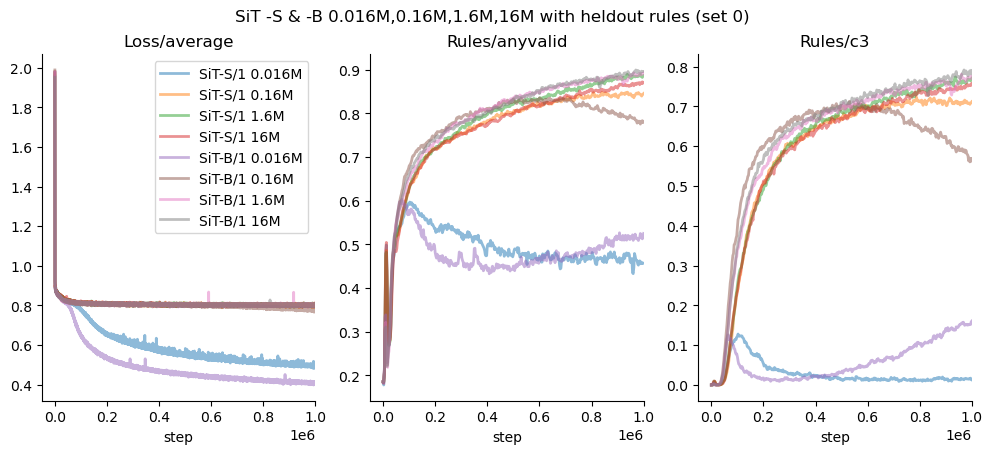

In [204]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        #'004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
        #'005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
        '013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs',
        '014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs',
        '012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs',
        '011-SiT_S_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs',
        '015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs',
        '017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs',
        '018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs',
        '016-SiT_B_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs',
        ]
labels = ["SiT-S/1 0.016M",
        "SiT-S/1 0.16M",
        "SiT-S/1 1.6M",
        "SiT-S/1 16M",
        "SiT-B/1 0.016M",
        "SiT-B/1 0.16M",
        "SiT-B/1 1.6M",
        "SiT-B/1 16M"]
figh = plot_learning_curve_cmp(tb_data_col_SiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("SiT -S & -B 0.016M,0.16M,1.6M,16M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "SiT_S+B_0.016M-16M_heldout0_cmp_curve", figh)

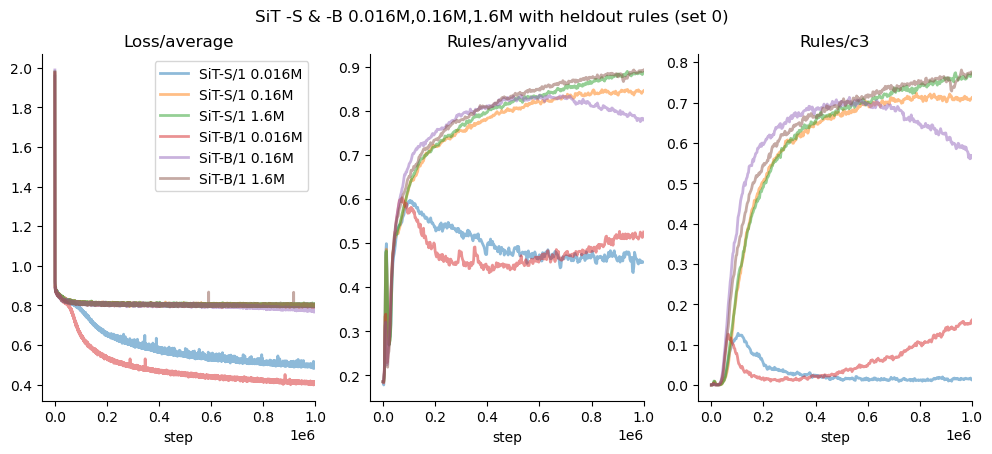

In [205]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        #'004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
        #'005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs',
        '013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs',
        '014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs',
        '012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs',
        # '011-SiT_S_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs',
        '015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs',
        '017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs',
        '018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs',
        # '016-SiT_B_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs',
        ]
labels = ["SiT-S/1 0.016M",
        "SiT-S/1 0.16M",
        "SiT-S/1 1.6M",
        # "SiT-S/1 16M",
        "SiT-B/1 0.016M",
        "SiT-B/1 0.16M",
        "SiT-B/1 1.6M",
        # "SiT-B/1 16M",
        ]
figh = plot_learning_curve_cmp(tb_data_col_SiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("SiT -S & -B 0.016M,0.16M,1.6M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "SiT_S+B_0.016M-1.6M_heldout0_cmp_curve", figh)

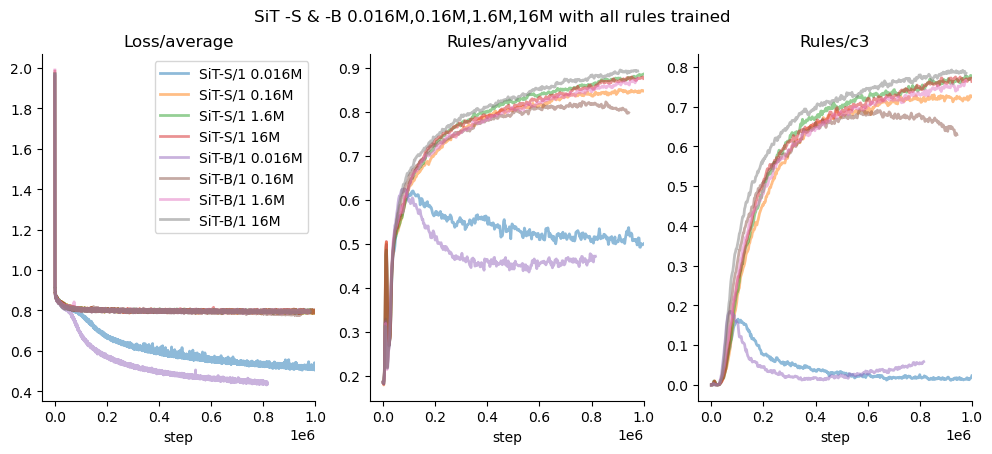

In [208]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        '006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs',
        '007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs',
        '008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs',
        '010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs',
        '012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs',
        '011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs',
        '014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs',
        '013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs',
        ]
labels = ["SiT-S/1 0.016M",
        "SiT-S/1 0.16M",
        "SiT-S/1 1.6M",
        "SiT-S/1 16M",
        "SiT-B/1 0.016M",
        "SiT-B/1 0.16M",
        "SiT-B/1 1.6M",
        "SiT-B/1 16M",
        ]
figh = plot_learning_curve_cmp(tb_data_col_SiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("SiT -S & -B 0.016M,0.16M,1.6M,16M with all rules trained")
figh.show()
saveallforms(figdir, "SiT_S+B_0.016M-16M_all_data_cmp_curve", figh)

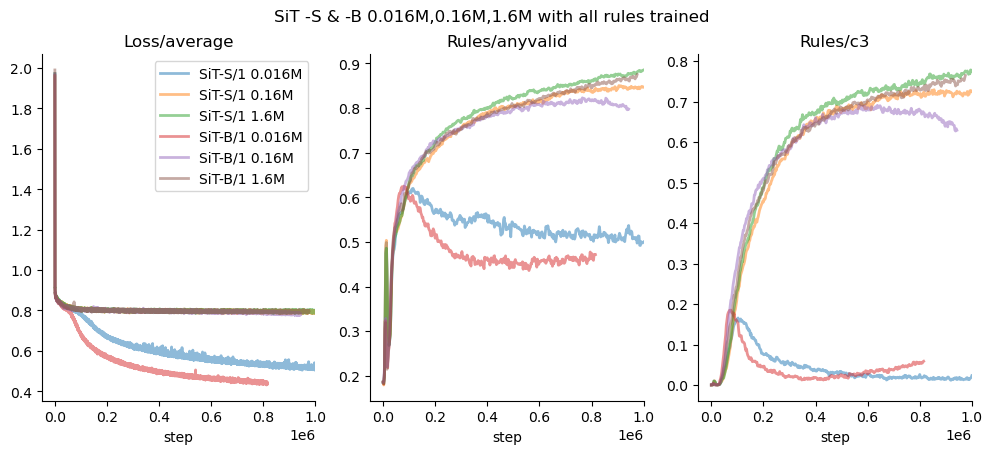

In [209]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        '006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs',
        '007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs',
        '008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs',
        # '010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs',
        '012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs',
        '011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs',
        '014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs',
        # '013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs',
        ]
labels = ["SiT-S/1 0.016M",
        "SiT-S/1 0.16M",
        "SiT-S/1 1.6M",
        # "SiT-S/1 16M",
        "SiT-B/1 0.016M",
        "SiT-B/1 0.16M",
        "SiT-B/1 1.6M",
        # "SiT-B/1 16M",
        ]
figh = plot_learning_curve_cmp(tb_data_col_SiT, varnames, runs, labels, xlim=10E5);
figh.suptitle("SiT -S & -B 0.016M,0.16M,1.6M with all rules trained")
figh.show()
saveallforms(figdir, "SiT_S+B_0.016M-1.6M_all_data_cmp_curve", figh)

### Scratch

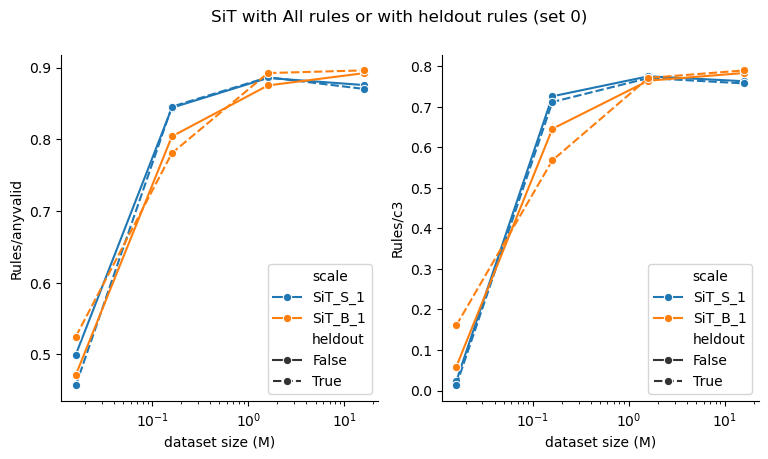

In [59]:
plt.subplots(1, 2, figsize=(9, 4.5))
plt.subplot(1, 2, 1)
sns.lineplot(data=syndf_SiT.loc[:, :], x="dataset_size", y="Rules/anyvalid", hue="scale", marker="o", style="heldout",) 
plt.xscale("log")
plt.xlabel("dataset size (M)")
plt.subplot(1, 2, 2)
sns.lineplot(data=syndf_SiT.loc[:, :], x="dataset_size", y="Rules/c3", hue="scale", marker="o", style="heldout",) 
plt.xscale("log")
plt.xlabel("dataset size (M)")
plt.suptitle("SiT with All rules or with heldout rules (set 0)")
saveallforms(SiTfigdir, "SiT_both_data_model_scale_heldout_cmp_curve")
plt.show()

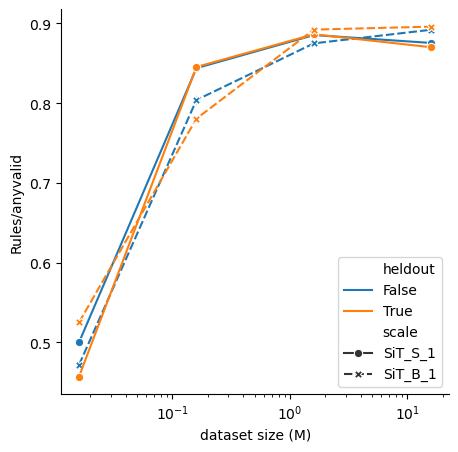

In [45]:
plt.figure(figsize=(5, 5))
sns.lineplot(data=syndf_SiT, x="dataset_size", y="Rules/anyvalid", hue="heldout", style="scale", markers=True)
plt.xscale("log")
plt.xlabel("dataset size (M)")
plt.show()

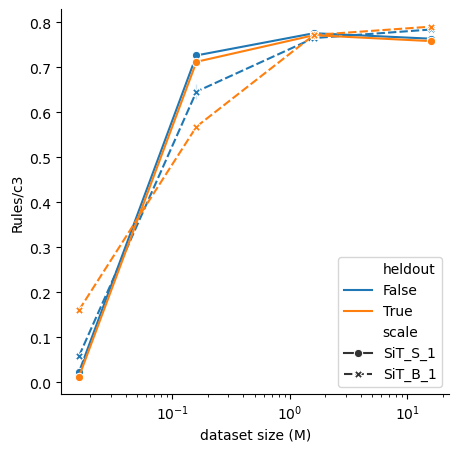

In [46]:
plt.figure(figsize=(5, 5))
sns.lineplot(data=syndf_SiT, x="dataset_size", y="Rules/c3", hue="heldout", style="scale", markers=True)
plt.xscale("log")
plt.xlabel("dataset size (M)")
plt.show()

## EDM

In [89]:
tb_data_col_EDM = extract_all_runs(EDM_exproot)

Extracted data from WideBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0105/tensorboard_logs
Extracted data from WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs
Extracted data from WideBlnrX3_new_stream0_48M_RAVEN10_abstract_20240705-1908/tensorboard_logs
Extracted data from BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2314/tensorboard_logs
Extracted data from WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs
Extracted data from BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs
Extracted data from BigBlnrX3_new_stream1_6M_RAVEN10_abstract_20240705-1903/tensorboard_logs
Extracted data from BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
Extracted data from BigBlnrX3_new_stream16M_RAVEN10_abstract_20240705-0237/tensorboard_logs
Extracted data from WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2207/tensorboard_logs
Ext

In [90]:
def simplify_runname_EDM(run_name):
    return run_name.replace("/tensorboard_logs", "").split("_2024")[0].replace("_RAVEN10_abstract", "")#.replace("_new", "")

syndf_EDM = extract_last_step_summary(tb_data_col_EDM, simplify_runname_EDM, exclude_runs=())
syndf_EDM

tag                                   Learning Rate  Loss/average  Loss/batch  \
run_name                                                                        
WideBlnrX3_new_stream0_016M                  0.0002      0.472555    0.344257   
WideBlnrX3_new_stream0_16M_heldout0          0.0002      0.643560    0.593999   
WideBlnrX3_new_stream0_48M                   0.0002      0.638694    0.590333   
BigBlnrX3_new_stream0_48M_heldout0           0.0002      0.636146    0.614749   
WideBlnrX3_new_stream0_016M_heldout0         0.0002      0.459644    0.410992   
BigBlnrX3_new_stream0_48M_heldout0           0.0002      0.636382    0.616904   
BigBlnrX3_new_stream1_6M                     0.0002      0.629097    0.633882   
BigBlnrX3_new_stream0_16M_heldout0           0.0002      0.708024    0.662795   
BigBlnrX3_new_stream16M                      0.0002      0.629170    0.621290   
WideBlnrX3_new_stream4_8M_heldout0           0.0002      0.647637    0.634478   
WideBlnrX3_new_stream16M_heldout0            0.0002      0.647776    0.636138   
WideBlnrX3_new_stream4_8M_heldout0           0.0002      0.734135    0.638439   
BigBlnrX3_new_stream0_48M_heldout0           0.0002      0.705918    0.767108   
WideBlnrX3_new_stream0_16M                   0.0002      0.638031    0.592863   
BigBlnrX3_new_stream0_16M_heldout0           0.0002      0.625357    0.557646   
WideBlnrX3_new_stream0_48M_heldout0          0.0002      0.646984    0.625755   
WideBlnrX3_new_stream1_6M_heldout0           0.0002      0.647314    0.643767   
BigBlnrX3_new_stream0_16M_heldout0           0.0002      0.624024    0.550257   
WideBlnrX3_new_stream4_8M                    0.0002      0.641472    0.606511   
BigBlnrX3_new_stream1_6M_heldout0            0.0002      0.637656    0.635912   
WideBlnrX3_new_stream1_6M                    0.0002      0.639531    0.577371   
BigBlnrX3_new_stream0_016M_heldout0          0.0002      0.330067    0.218826   
WideBlnrX3_new_stream16M                     0.0002      0.637981    0.609180   
BigBlnrX3_new_stream4_8M                     0.0002      0.628317    0.639653   
BigBlnrX3_new_stream16M_heldout0             0.0002      0.637376    0.592674   
BigBlnrX3_new_stream4_8M_heldout0            0.0002      0.636490    0.593334   
WideBlnrX3_new_stream4_8M_heldout0           0.0002      0.646791    0.635782   
BigBlnrX3_new_stream0_016M                   0.0002      0.348312    0.312391   

tag                                   Rules/anyvalid  Rules/anyvalid_cnt  \
run_name                                                                   
WideBlnrX3_new_stream0_016M                 0.547038              3361.0   
WideBlnrX3_new_stream0_16M_heldout0         0.710286              4364.0   
WideBlnrX3_new_stream0_48M                  0.739746              4545.0   
BigBlnrX3_new_stream0_48M_heldout0          0.749023              4602.0   
WideBlnrX3_new_stream0_016M_heldout0        0.546712              3359.0   
BigBlnrX3_new_stream0_48M_heldout0          0.749512              4605.0   
BigBlnrX3_new_stream1_6M                    0.745605              4581.0   
BigBlnrX3_new_stream0_16M_heldout0          0.651204              4001.0   
BigBlnrX3_new_stream16M                     0.750814              4613.0   
WideBlnrX3_new_stream4_8M_heldout0          0.725098              4455.0   
WideBlnrX3_new_stream16M_heldout0           0.729492              4482.0   
WideBlnrX3_new_stream4_8M_heldout0          0.576660              3543.0   
BigBlnrX3_new_stream0_48M_heldout0          0.633301              3891.0   
WideBlnrX3_new_stream0_16M                  0.748047              4596.0   
BigBlnrX3_new_stream0_16M_heldout0          0.700684              4305.0   
WideBlnrX3_new_stream0_48M_heldout0         0.754232              4634.0   
WideBlnrX3_new_stream1_6M_heldout0          0.716960              4405.0   
BigBlnrX3_new_stream0_16M_heldout0          0.700521              4304.0   
WideBlnrX3_new_stream4_8M                   0.717

In [ ]:
syndf_EDM.index[syndf_EDM.index.duplicated()]

Index(['BigBlnrX3_stream0_48M_heldout0', 'WideBlnrX3_stream4_8M_heldout0',
       'BigBlnrX3_stream0_48M_heldout0', 'BigBlnrX3_stream0_16M_heldout0',
       'BigBlnrX3_stream0_16M_heldout0', 'WideBlnrX3_stream4_8M_heldout0'],
      dtype='object', name='run_name')

In [99]:
def simplify_runname_EDM(run_name):
    return run_name.replace("/tensorboard_logs", "").split("_2024")[0].replace("_RAVEN10_abstract", "")#.replace("_new", "")

excluded_runs = [
    "BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs", # 75200
    "WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs", # 67500
    "BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs", # 79200
    # "WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs",
    ] # 873100

syndf_EDM = extract_last_step_summary(tb_data_col_EDM, simplify_runname_EDM, exclude_runs=excluded_runs)
syndf_EDM.sort_index(inplace=True)
syndf_EDM

Excluding BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
Excluding WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs
Excluding BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs


tag                                   Learning Rate  Loss/average  Loss/batch  \
run_name                                                                        
BigBlnrX3_new_stream0_016M                   0.0002      0.348312    0.312391   
BigBlnrX3_new_stream0_016M_heldout0          0.0002      0.330067    0.218826   
BigBlnrX3_new_stream0_16M_heldout0           0.0002      0.624024    0.550257   
BigBlnrX3_new_stream0_16M_heldout0           0.0002      0.625357    0.557646   
BigBlnrX3_new_stream0_48M_heldout0           0.0002      0.636146    0.614749   
BigBlnrX3_new_stream0_48M_heldout0           0.0002      0.636382    0.616904   
BigBlnrX3_new_stream16M                      0.0002      0.629170    0.621290   
BigBlnrX3_new_stream16M_heldout0             0.0002      0.637376    0.592674   
BigBlnrX3_new_stream1_6M                     0.0002      0.629097    0.633882   
BigBlnrX3_new_stream1_6M_heldout0            0.0002      0.637656    0.635912   
BigBlnrX3_new_stream4_8M                     0.0002      0.628317    0.639653   
BigBlnrX3_new_stream4_8M_heldout0            0.0002      0.636490    0.593334   
WideBlnrX3_new_stream0_016M                  0.0002      0.472555    0.344257   
WideBlnrX3_new_stream0_016M_heldout0         0.0002      0.459644    0.410992   
WideBlnrX3_new_stream0_16M                   0.0002      0.638031    0.592863   
WideBlnrX3_new_stream0_16M_heldout0          0.0002      0.643560    0.593999   
WideBlnrX3_new_stream0_48M                   0.0002      0.638694    0.590333   
WideBlnrX3_new_stream0_48M_heldout0          0.0002      0.646984    0.625755   
WideBlnrX3_new_stream16M                     0.0002      0.637981    0.609180   
WideBlnrX3_new_stream16M_heldout0            0.0002      0.647776    0.636138   
WideBlnrX3_new_stream1_6M                    0.0002      0.639531    0.577371   
WideBlnrX3_new_stream1_6M_heldout0           0.0002      0.647314    0.643767   
WideBlnrX3_new_stream4_8M                    0.0002      0.641472    0.606511   
WideBlnrX3_new_stream4_8M_heldout0           0.0002      0.647637    0.634478   
WideBlnrX3_new_stream4_8M_heldout0           0.0002      0.646791    0.635782   

tag                                   Rules/anyvalid  Rules/anyvalid_cnt  \
run_name                                                                   
BigBlnrX3_new_stream0_016M                  0.555827              3415.0   
BigBlnrX3_new_stream0_016M_heldout0         0.577474              3548.0   
BigBlnrX3_new_stream0_16M_heldout0          0.700521              4304.0   
BigBlnrX3_new_stream0_16M_heldout0          0.700684              4305.0   
BigBlnrX3_new_stream0_48M_heldout0          0.749023              4602.0   
BigBlnrX3_new_stream0_48M_heldout0          0.749512              4605.0   
BigBlnrX3_new_stream16M                     0.750814              4613.0   
BigBlnrX3_new_stream16M_heldout0            0.713216              4382.0   
BigBlnrX3_new_stream1_6M                    0.745605              4581.0   
BigBlnrX3_new_stream1_6M_heldout0           0.735189              4517.0   
BigBlnrX3_new_stream4_8M                    0.758952              4663.0   
BigBlnrX3_new_stream4_8M_heldout0           0.723145              4443.0   
WideBlnrX3_new_stream0_016M                 0.547038              3361.0   
WideBlnrX3_new_stream0_016M_heldout0        0.546712              3359.0   
WideBlnrX3_new_stream0_16M                  0.748047              4596.0   
WideBlnrX3_new_stream0_16M_heldout0         0.710286              4364.0   
WideBlnrX3_new_stream0_48M                  0.739746              4545.0   
WideBlnrX3_new_stream0_48M_heldout0         0.754232              4634.0   
WideBlnrX3_new_stream16M                    0.733887              4509.0   
WideBlnrX3_new_stream16M_heldout0           0.729492              4482.0   
WideBlnrX3_new_stream1_6M                   0.742188              4560.0   
WideBlnrX3_new_stream1_6M_heldout0          0.716960            

In [100]:
syndf_EDM.to_csv(join(tabdir, "EDM_raven_tensorboard_data.csv"))
pkl.dump(tb_data_col_EDM, open(join(tabdir, "EDM_raven_tensorboard_raw_data.pkl"), "wb"))

### Plot Scaling curve

In [137]:
syndf_EDM = pd.read_csv(join(tabdir, "EDM_raven_tensorboard_data.csv"), index_col=0)
tb_data_col_EDM = pkl.load(open(join(tabdir, "EDM_raven_tensorboard_raw_data.pkl"), "rb"))

In [138]:
syndf_EDM["dataset_size"] = syndf_EDM.index.map(extract_and_convert)
syndf_EDM["heldout"] = syndf_EDM.index.map(lambda x: "_heldout0" in x)
syndf_EDM["scale"] = syndf_EDM.index.map(lambda x: "EDMx2" if "WideBlnrX3" in x else "EDMx3" if "BigBlnrX3" in x else None)

In [139]:
# some datapoints seems missing from the dataset size, now let's run the missing experimetns 
syndf_EDM.loc[syndf_EDM.heldout==False, :]

Learning Rate  Loss/average  Loss/batch  \
run_name                                                               
BigBlnrX3_new_stream0_016M          0.0002      0.348312    0.312391   
BigBlnrX3_new_stream16M             0.0002      0.629170    0.621290   
BigBlnrX3_new_stream1_6M            0.0002      0.629097    0.633882   
BigBlnrX3_new_stream4_8M            0.0002      0.628317    0.639653   
WideBlnrX3_new_stream0_016M         0.0002      0.472555    0.344257   
WideBlnrX3_new_stream0_16M          0.0002      0.638031    0.592863   
WideBlnrX3_new_stream0_48M          0.0002      0.638694    0.590333   
WideBlnrX3_new_stream16M            0.0002      0.637981    0.609180   
WideBlnrX3_new_stream1_6M           0.0002      0.639531    0.577371   
WideBlnrX3_new_stream4_8M           0.0002      0.641472    0.606511   

                             Rules/anyvalid  Rules/anyvalid_cnt  Rules/c2  \
run_name                                                                    
BigBlnrX3_new_stream0_016M         0.555827              3415.0  0.147949   
BigBlnrX3_new_stream16M            0.750814              4613.0  0.132324   
BigBlnrX3_new_stream1_6M           0.745605              4581.0  0.142090   
BigBlnrX3_new_stream4_8M           0.758952              4663.0  0.137695   
WideBlnrX3_new_stream0_016M        0.547038              3361.0  0.139160   
WideBlnrX3_new_stream0_16M         0.748047              4596.0  0.209473   
WideBlnrX3_new_stream0_48M         0.739746              4545.0  0.169922   
WideBlnrX3_new_stream16M           0.733887              4509.0  0.172852   
WideBlnrX3_new_stream1_6M          0.742188              4560.0  0.182129   
WideBlnrX3_new_stream4_8M          0.717611              4409.0  0.153809   

                             Rules/c2_cnt  Rules/c3  Rules/c3_cnt  \
run_name                                                            
BigBlnrX3_new_stream0_016M          303.0  0.053223         109.0   
BigBlnrX3_new_stream16M             271.0  0.600586        1230.0   
BigBlnrX3_new_stream1_6M            291.0  0.589355        1207.0   
BigBlnrX3_new_stream4_8M            282.0  0.607910        1245.0   
WideBlnrX3_new_stream0_016M         285.0  0.022461          46.0   
WideBlnrX3_new_stream0_16M          429.0  0.494629        1013.0   
WideBlnrX3_new_stream0_48M          348.0  0.535645        1097.0   
WideBlnrX3_new_stream16M            354.0  0.531250        1088.0   
WideBlnrX3_new_stream1_6M           373.0  0.529785        1085.0   
WideBlnrX3_new_stream4_8M           315.0  0.524902        1075.0   

                                                                                               full_name  \
run_name                                                                                                   
BigBlnrX3_new_stream0_016M    BigBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0104/tensorboard_logs   
BigBlnrX3_new_stream16M          BigBlnrX3_new_stream16M_RAVEN10_abstract_20240705-0237/tensorboard_logs   
BigBlnrX3_new_stream1_6M        BigBlnrX3_new_stream1_6M_RAVEN10_abstract_20240705-1903/tensorboard_logs   
BigBlnrX3_new_stream4_8M        BigBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1903/tensorboard_logs   
WideBlnrX3_new_stream0_016M  WideBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0105/tensorboard_logs   
WideBlnrX3_new_stream0_16M    WideBlnrX3_new_stream0_16M_RAVEN10_abstract_20240705-1908/tensorboard_logs   
WideBlnrX3_new_stream0_48M    WideBlnrX3_new_stream0_48M_RAVEN10_abstract_20240705-1908/tensorboard_logs   
WideBlnrX3_new_stream16M        WideBlnrX3_new_stream16M_RAVEN10_abstract_20240705-0023/tensorboard_logs   
WideBlnrX3_new_stream1_6M      WideBlnrX3_new_stream1_6M_RAVEN10_abstract_20240705-1908/tensorboard_logs   
WideBlnrX3_new_stream4_8M      WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs   

                               step  step/epoch  dataset_size  heldout  scale  
run_name                         

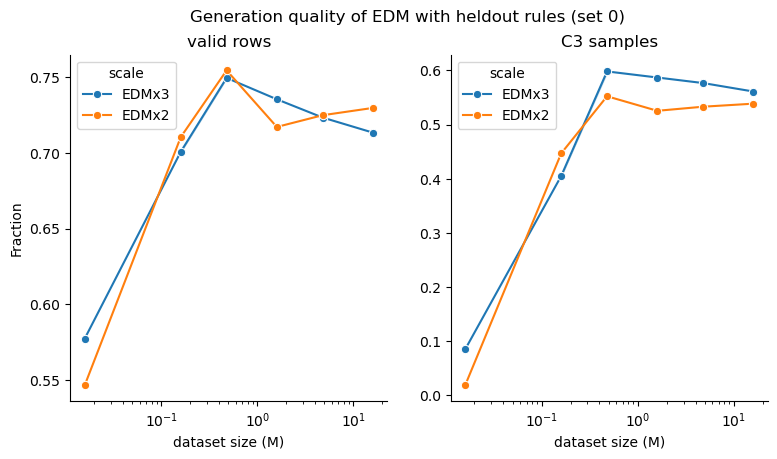

In [141]:
figh = plot_data_scaling_curve_syndf(syndf_EDM, syndf_EDM.heldout==True)
plt.suptitle("Generation quality of EDM with heldout rules (set 0)")
saveallforms(figdir, "EDM_heldout0_data_model_scale_cmp_curve", figh)

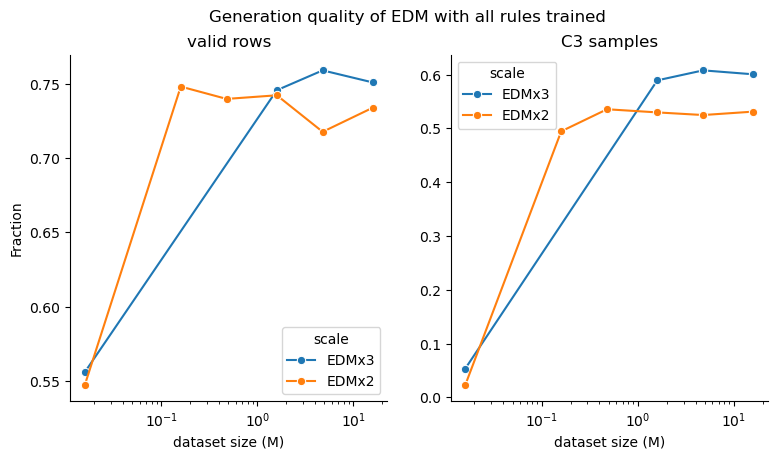

In [142]:
figh = plot_data_scaling_curve_syndf(syndf_EDM, syndf_EDM.heldout==False)
plt.suptitle("Generation quality of EDM with all rules trained")
saveallforms(figdir, "EDM_all_data_model_scale_cmp_curve", figh)

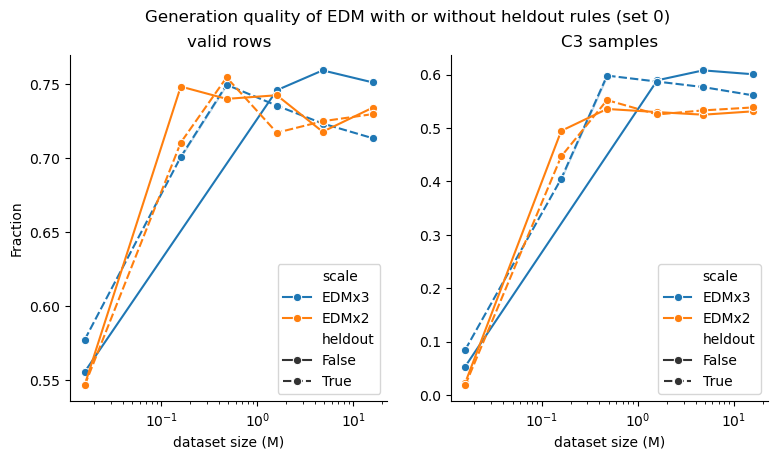

In [143]:
figh = plot_data_scaling_curve_syndf(syndf_EDM, None, stylevar="heldout", huevar="scale")
plt.suptitle("Generation quality of EDM with or without heldout rules (set 0)")
saveallforms(figdir, "EDM_both_data_model_scale_heldout_cmp_curve", figh)

### Plot Learning curve cmp

In [168]:
sorted(list(tb_data_col_EDM.keys()))

['BigBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0104/tensorboard_logs',
 'BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs',
 'BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs',
 'BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs',
 'BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs',
 'BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs',
 'BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2314/tensorboard_logs',
 'BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs',
 'BigBlnrX3_new_stream16M_RAVEN10_abstract_20240705-0237/tensorboard_logs',
 'BigBlnrX3_new_stream16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs',
 'BigBlnrX3_new_stream1_6M_RAVEN10_abstract_20240705-1903/tensorboard_logs',
 'BigBlnrX3_new_stream1_6M_heldout0_RAVEN10_abstract_20240708-2052/tensor

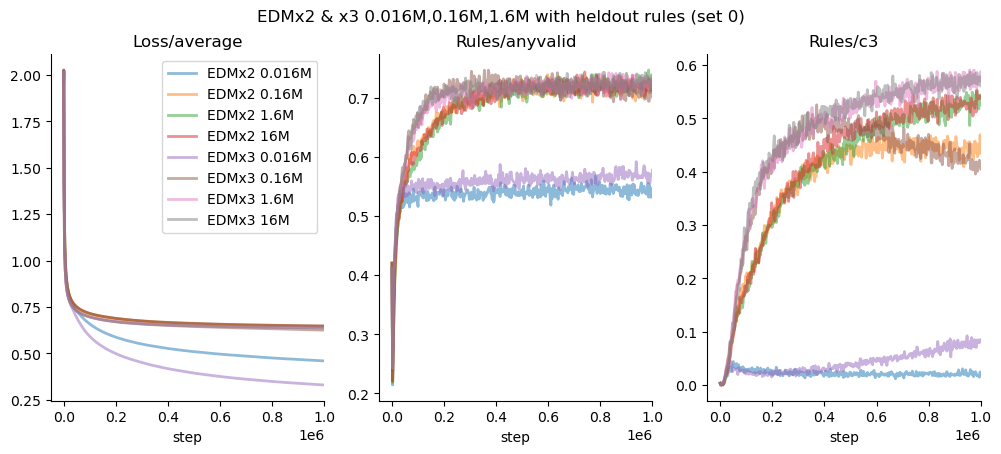

In [193]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        'WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs',
        'WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs',
        'WideBlnrX3_new_stream1_6M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs',
        'WideBlnrX3_new_stream16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs',
        'BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs',
        'BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs',
        'BigBlnrX3_new_stream1_6M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs',
        'BigBlnrX3_new_stream16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs',
        ]
labels = ["EDMx2 0.016M",
          "EDMx2 0.16M",
          "EDMx2 1.6M",
          "EDMx2 16M",
          "EDMx3 0.016M",
          "EDMx3 0.16M",
          "EDMx3 1.6M",
          "EDMx3 16M",
          ]
figh = plot_learning_curve_cmp(tb_data_col_EDM, varnames, runs, labels, xlim=10E5);
figh.suptitle("EDMx2 & x3 0.016M,0.16M,1.6M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "EDMx2x3_0.016M-16M_heldout0_scale_cmp_curve", figh)

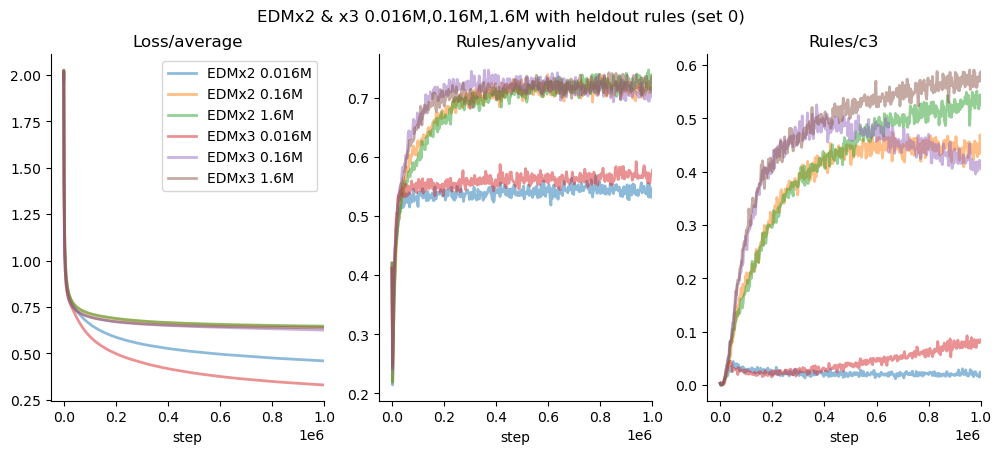

In [194]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        'WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs',
        'WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs',
        'WideBlnrX3_new_stream1_6M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs',
        'BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs',
        'BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs',
        'BigBlnrX3_new_stream1_6M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs',
        ]
labels = ["EDMx2 0.016M",
          "EDMx2 0.16M",
          "EDMx2 1.6M",
          "EDMx3 0.016M",
          "EDMx3 0.16M",
          "EDMx3 1.6M",
          ]
figh = plot_learning_curve_cmp(tb_data_col_EDM, varnames, runs, labels, xlim=10E5);
figh.suptitle("EDMx2 & x3 0.016M,0.16M,1.6M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "EDMx2x3_0.016M-1.6M_heldout0_scale_cmp_curve", figh)

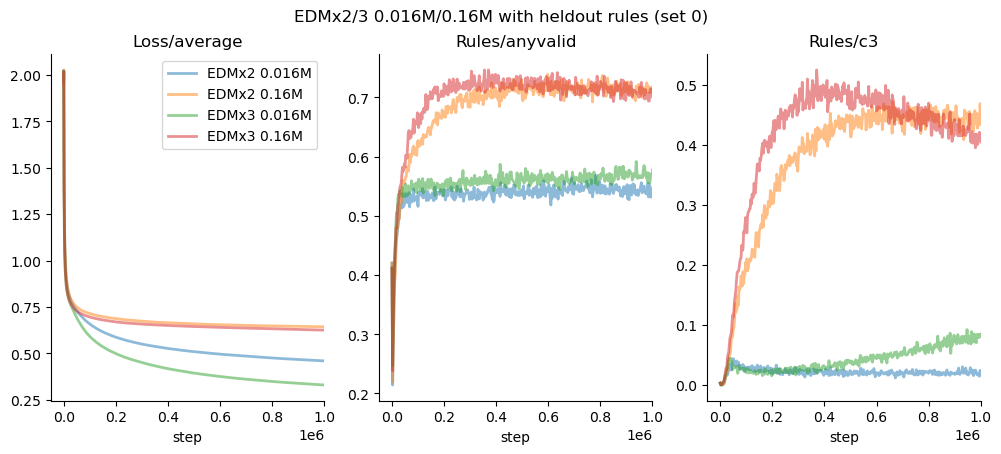

In [195]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        'WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs',
        'WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs',
        'BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs',
        'BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs',
        ]
labels = ["EDMx2 0.016M",
          "EDMx2 0.16M",
          "EDMx3 0.016M",
          "EDMx3 0.16M"]
figh = plot_learning_curve_cmp(tb_data_col_EDM, varnames, runs, labels, xlim=10E5);
figh.suptitle("EDMx2/3 0.016M/0.16M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "EDMx2x3_0.016M-0.16M_heldout0_scale_cmp_curve", figh)

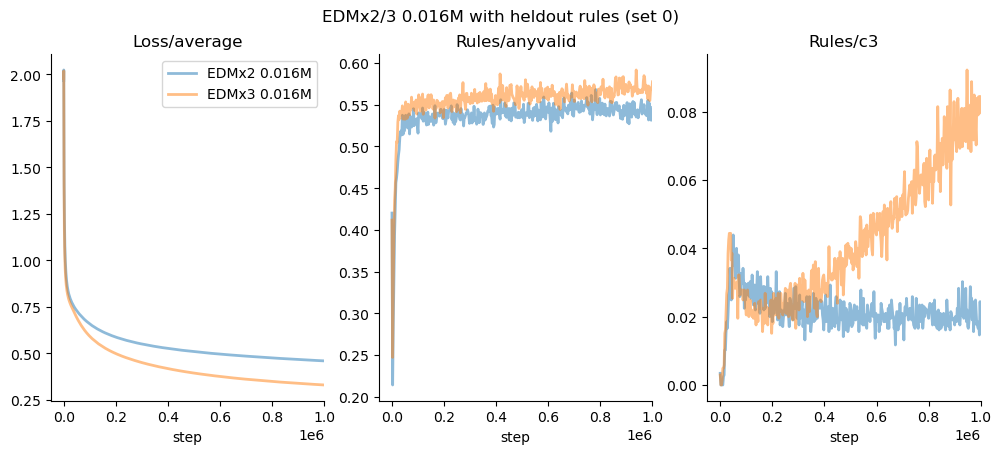

In [196]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        'WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs',
        'BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs',
        ]
labels = ["EDMx2 0.016M",
          "EDMx3 0.016M",]
figh = plot_learning_curve_cmp(tb_data_col_EDM, varnames, runs, labels, xlim=10E5);
figh.suptitle("EDMx2/3 0.016M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "EDMx2x3_0.016M_heldout0_scale_cmp_curve", figh)

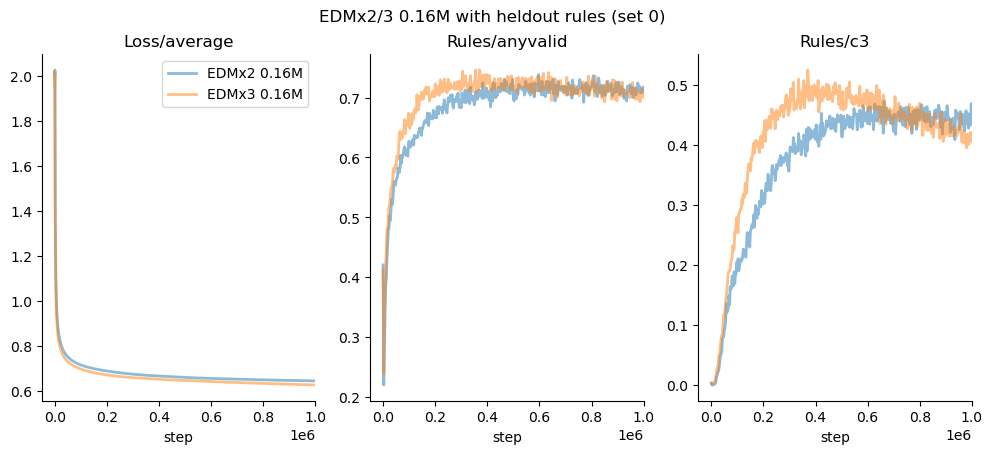

In [197]:
# Example usage:
varnames = ["Loss/average", 'Rules/anyvalid', "Rules/c3"]
runs = [
        'WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs',
        'BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs',
        ]
labels = ["EDMx2 0.16M",
          "EDMx3 0.16M",]
figh = plot_learning_curve_cmp(tb_data_col_EDM, varnames, runs, labels, xlim=10E5);
figh.suptitle("EDMx2/3 0.16M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "EDMx2x3_0.16M_heldout0_scale_cmp_curve", figh)

## Diffusion model Combined Synopsis

In [155]:
syndf_EDM["model_class"] = "UNet"
syndf_DiT["model_class"] = "DiT"    
syndf_SiT["model_class"] = "SiT"
syndf_diff = pd.concat([syndf_EDM, syndf_DiT, syndf_SiT], axis=0)
syndf_diff["scale"] = syndf_diff["scale"].apply(lambda x: x.replace("_S_1", "-S/1").replace("_B_1", "-B/1"))

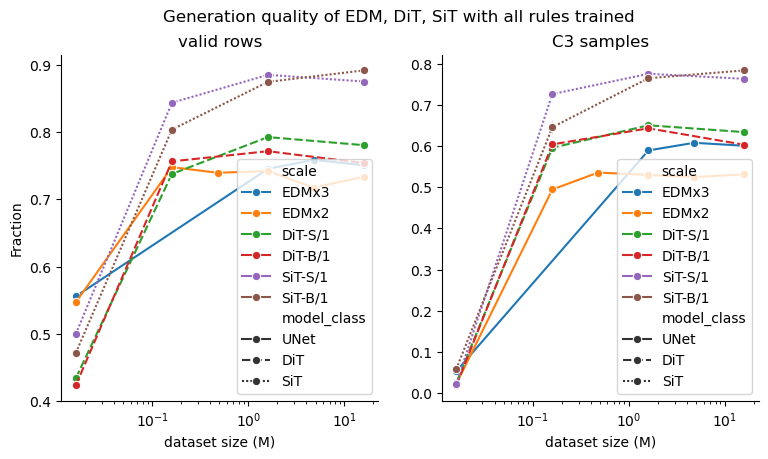

In [160]:
figh = plot_data_scaling_curve_syndf(syndf_diff, ~syndf_diff.heldout, stylevar="model_class", huevar="scale")
plt.suptitle("Generation quality of EDM, DiT, SiT with all rules trained")
saveallforms(figdir, "EDM_DiT_SiT_all_data_model_scale_cmp_curve", figh)

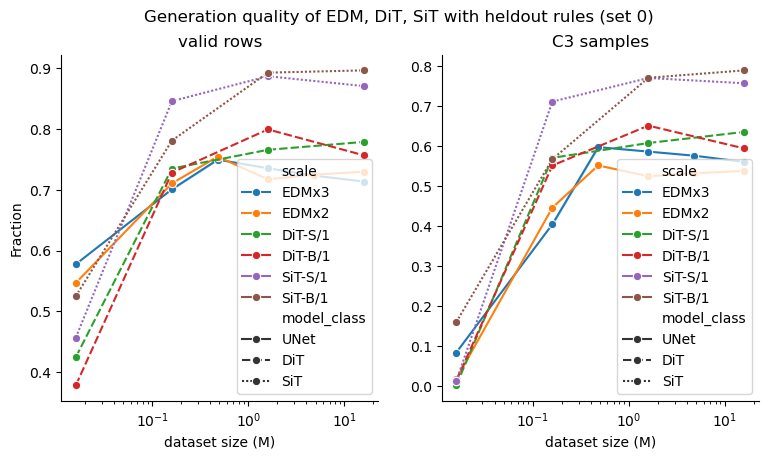

In [161]:
figh = plot_data_scaling_curve_syndf(syndf_diff, syndf_diff.heldout, stylevar="model_class", huevar="scale")
figh.suptitle("Generation quality of EDM, DiT, SiT with heldout rules (set 0)")
saveallforms(figdir, "EDM_DiT_SiT_heldout0_data_model_scale_cmp_curve", figh)

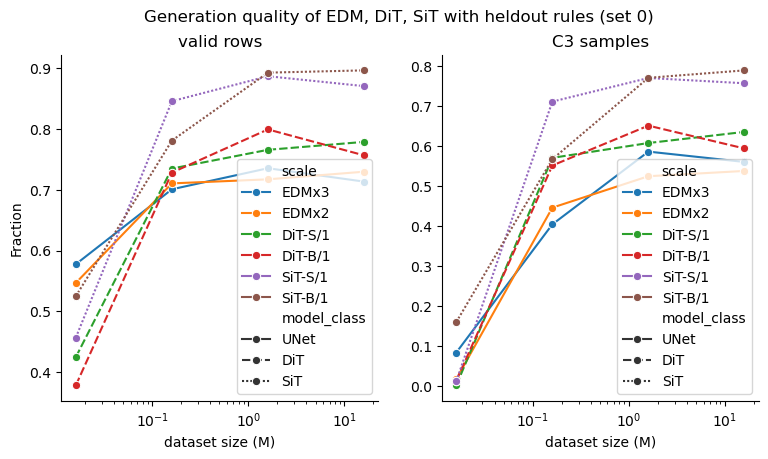

In [162]:
figh = plot_data_scaling_curve_syndf(syndf_diff, syndf_diff.heldout & (syndf_diff.dataset_size != 0.48) & (syndf_diff.dataset_size != 4.8) 
                                     , stylevar="model_class", huevar="scale")
figh.suptitle("Generation quality of EDM, DiT, SiT with heldout rules (set 0)")
saveallforms(figdir, "EDM_DiT_SiT_heldout0_data_model_scale_cmp_curve_prune", figh)

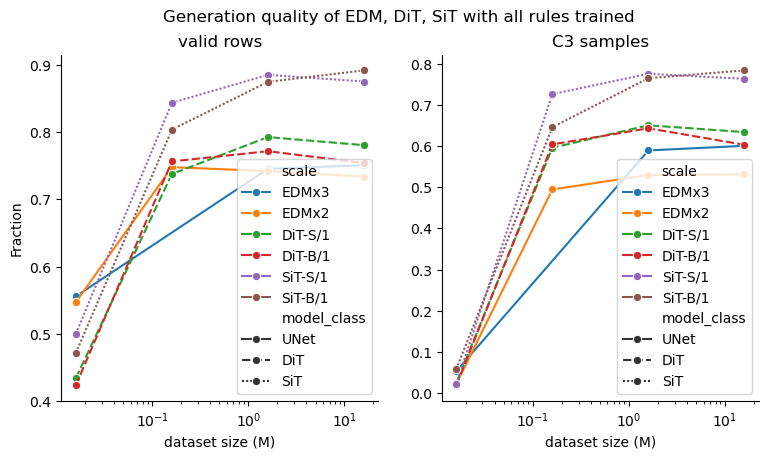

In [163]:
figh = plot_data_scaling_curve_syndf(syndf_diff, ~syndf_diff.heldout & (syndf_diff.dataset_size != 0.48) & (syndf_diff.dataset_size != 4.8) 
                                     , stylevar="model_class", huevar="scale")
figh.suptitle("Generation quality of EDM, DiT, SiT with all rules trained")
saveallforms(figdir, "EDM_DiT_SiT_all_data_model_scale_cmp_curve_prune", figh)

## GPT2

In [219]:
GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
tb_data_col_GPT = extract_all_runs(GPT_exproot)

Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240819-010648/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240704-041344/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240819-011524/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_cond_all-20240702-032839/tensorboard_logs
Extracted data from GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs
Extracted data from GPT2_base_RAVEN_uncond_heldout0-20240630-023945/tensorboard_logs
Extracted data from GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240818-013524/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_all_stream16M-20240704-025623/tensorboard_logs
Extracted data from GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240819-010648/tensorboard_logs
Extracted data from GPT2_base_RAVEN_uncond_heldout0_stream0_16M

In [221]:
def simplify_runname(run_name):
    return run_name.replace("/tensorboard_logs", "").split("-2024")[0].replace("_RAVEN", "")

syndf_GPT = extract_last_step_summary(tb_data_col_GPT, simplify_runname)
syndf_GPT

tag                                       Loss/train  Train/Avg_Loss  \
run_name                                                               
GPT2_medium_uncond_heldout0_stream16M       3.238008        3.205984   
GPT2_medium_uncond_heldout0_stream1_6M      3.191897             NaN   
GPT2_medium_uncond_heldout0_stream16M       3.196153        3.244510   
GPT2_medium_uncond_heldout0_stream0_16M     0.507333             NaN   
GPT2_medium_cond_all                        0.475036        0.482606   
GPT2_small_uncond_heldout0_stream16M        3.244263        3.223624   
GPT2_base_uncond_heldout0                   1.238913        1.439255   
GPT2_base_uncond_heldout0_stream1_6M        4.270813             NaN   
GPT2_medium_uncond_all_stream16M            3.208654        3.200251   
GPT2_medium_uncond_heldout0_stream16M       3.156555             NaN   
GPT2_base_uncond_heldout0_stream0_16M       0.448800        1.050831   
GPT2_small_uncond_heldout0_stream0_016M     0.178954        0.305875   
GPT2_medium_uncond_heldout0_stream0_16M     0.235797        0.625034   
GPT2_base_uncond_heldout0_stream16M         3.293100             NaN   
GPT2_base_uncond_heldout0_stream1_6M        2.897712        3.115486   
GPT2_small_uncond_heldout0_stream1_6M       2.988280        3.123017   
GPT2_base_uncond_heldout0_stream1_6M        2.754833             NaN   
GPT2_small_uncond_heldout0_stream1_6M       3.157612        3.207781   
GPT2_medium_uncond_heldout0_stream0_016M    0.178184             NaN   
GPT2_base_uncond_heldout0_stream16M         3.141927        3.211074   
GPT2_medium_uncond_heldout0_stream0_016M    0.176842        0.212783   
GPT2_base_uncond_heldout0_stream1_6M        3.644078             NaN   
GPT2_medium_cond_heldout0                   0.425383        0.427759   
GPT2_base_uncond_heldout0_stream0_016M      0.175103        0.224280   
GPT2_base_uncond_heldout0_stream0_016M      0.175733             NaN   
GPT2_base_cond_heldout0                     1.239679        1.258030   
GPT2_medium_cond_all_stream16M              2.841955        3.115757   
GPT2_base_uncond_heldout0_stream0_16M       0.813857             NaN   
GPT2_medium_uncond_heldout0_stream1_6M      2.640719        2.964224   
GPT2_medium_uncond_all                      0.638258        0.631115   
GPT2CmbEmb_base_uncond_heldout0             1.481050        1.551615   
GPT2_medium_uncond_heldout0                 0.524553        0.523315   
GPT2_base_uncond_heldout0_stream1_6M        3.124040             NaN   
GPT2_small_uncond_heldout0_stream0_16M      1.903041        2.312939   

tag                                       Val/AnyValid  Val/AnyValid_abinit  \
run_name                                                                      
GPT2_medium_uncond_heldout0_stream16M         0.957333             0.324333   
GPT2_medium_uncond_heldout0_stream1_6M        0.940667             0.377500   
GPT2_medium_uncond_heldout0_stream16M         0.962333             0.375000   
GPT2_medium_uncond_heldout0_stream0_16M       0.905000             0.504000   
GPT2_medium_cond_all                          0.960500             0.684833   
GPT2_small_uncond_heldout0_stream16M          0.950833             0.359000   
GPT2_base_uncond_heldout0                     0.911000             0.486003   
GPT2_base_uncond_heldout0_stream1_6M               NaN                  NaN   
GPT2_medium_uncond_all_stream16M              0.977000             0.379333   
GPT2_medium_uncond_heldout0_stream16M         0.957667             0.371167   
GPT2_base_uncond_heldout0_stream0_16M         0.904333             0.516833   
GPT2_small_uncond_heldout0_stream0_016M       0.841167             0.711000   
GPT2_medium_uncond_heldout0_stream0_16M       0.906167             0.616333   
GPT2_base_uncond_heldout0_stream16M           0.949667             0.277667   
GPT2_base_uncond_heldout0_stream1_6M          0.953667             0.442000   
GPT2_small_uncond_heldout0_stream1_6M         0.937000          

In [222]:
syndf_GPT.to_csv(join(tabdir, "GPT2_raven_tensorboard_data.csv"))
pkl.dump(tb_data_col_GPT, open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "wb"))

### Plot Scaling curves

In [ ]:
syn_df_GPT = pd.read_csv(join(tabdir, "GPT2_raven_tensorboard_data.csv"), index_col=0)
tb_data_col_GPT = pkl.load(open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "rb"))

In [225]:
syndf_GPT_sel = syndf_GPT.loc[syndf_GPT["step/epoch"]>809999,:]

In [247]:
syndf_GPT_sel.sort_index(inplace=True)
syndf_GPT_sel

/tmp/ipykernel_3607304/3720552585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndf_GPT_sel.sort_index(inplace=True)


tag                                       Loss/train  Train/Avg_Loss  \
run_name                                                               
GPT2_base_uncond_heldout0_stream0_016M      0.175103        0.224280   
GPT2_base_uncond_heldout0_stream0_16M       0.448800        1.050831   
GPT2_base_uncond_heldout0_stream16M         3.141927        3.211074   
GPT2_base_uncond_heldout0_stream1_6M        2.897712        3.115486   
GPT2_medium_uncond_heldout0_stream0_016M    0.176842        0.212783   
GPT2_medium_uncond_heldout0_stream0_16M     0.235797        0.625034   
GPT2_medium_uncond_heldout0_stream16M       3.238008        3.205984   
GPT2_medium_uncond_heldout0_stream1_6M      2.640719        2.964224   
GPT2_small_uncond_heldout0_stream0_016M     0.178954        0.305875   
GPT2_small_uncond_heldout0_stream0_16M      1.903041        2.312939   
GPT2_small_uncond_heldout0_stream16M        3.244263        3.223624   
GPT2_small_uncond_heldout0_stream1_6M       2.988280        3.123017   
GPT2_small_uncond_heldout0_stream1_6M       3.157612        3.207781   

tag                                       Val/AnyValid  Val/AnyValid_abinit  \
run_name                                                                      
GPT2_base_uncond_heldout0_stream0_016M        0.839167             0.747000   
GPT2_base_uncond_heldout0_stream0_16M         0.904333             0.516833   
GPT2_base_uncond_heldout0_stream16M           0.965000             0.299833   
GPT2_base_uncond_heldout0_stream1_6M          0.953667             0.442000   
GPT2_medium_uncond_heldout0_stream0_016M      0.822667             0.723167   
GPT2_medium_uncond_heldout0_stream0_16M       0.906167             0.616333   
GPT2_medium_uncond_heldout0_stream16M         0.957333             0.324333   
GPT2_medium_uncond_heldout0_stream1_6M        0.968167             0.457833   
GPT2_small_uncond_heldout0_stream0_016M       0.841167             0.711000   
GPT2_small_uncond_heldout0_stream0_16M        0.911333             0.445000   
GPT2_small_uncond_heldout0_stream16M          0.950833             0.359000   
GPT2_small_uncond_heldout0_stream1_6M         0.937000             0.437667   
GPT2_small_uncond_heldout0_stream1_6M         0.937500             0.417667   

tag                                       Val/Avg_Loss  Val/C2  Val/C2_abinit  \
run_name                                                                        
GPT2_base_uncond_heldout0_stream0_016M       27.119562  0.8870         0.1760   
GPT2_base_uncond_heldout0_stream0_16M        15.820763  0.3940         0.1660   
GPT2_base_uncond_heldout0_stream16M           3.339064  0.2065         0.1390   
GPT2_base_uncond_heldout0_stream1_6M          3.754040  0.2225         0.2300   
GPT2_medium_uncond_heldout0_stream0_016M     24.934677  0.9050         0.1875   
GPT2_medium_uncond_heldout0_stream0_16M      21.655064  0.3750         0.1830   
GPT2_medium_uncond_heldout0_stream16M         3.307848  0.2100         0.1470   
GPT2_medium_uncond_heldout0_stream1_6M        4.665191  0.1715         0.2720   
GPT2_small_uncond_heldout0_stream0_016M      26.369364  0.8935         0.1245   
GPT2_small_uncond_heldout0_stream0_16M        7.219540  0.3620         0.1445   
GPT2_small_uncond_heldout0_stream16M          3.317656  0.2270         0.1770   
GPT2_small_uncond_heldout0_stream1_6M         3.576402  0.2710         0.2240   
GPT2_small_uncond_heldout0_stream1_6M         3.377686  0.2820         0.2120   

tag                                       Val/C3  Val/C3_abinit   lr  \
run_name                                                               
GPT2_base_uncond_heldout0_stream0_016M    0.1130         0.4545  0.0   
GPT2_base_uncond_heldout0_stream0_16M     0.6060         0.2230  0.0   
GPT2_base_uncond_heldout0_stream16M       0.7935         0.0240  0.0   
GPT2_base_uncond_heldout0_stream1_6M      0.7775         0.1070  0.0   
GPT2_medium_uncond_heldout0_stream0_016M  0.0950         0.4200  0.0   
GPT2_medium_u

In [227]:
syndf_GPT_sel["heldout"] = syndf_GPT_sel.index.map(lambda x: "_heldout0" in x)
syndf_GPT_sel["dataset_size"] = syndf_GPT_sel.index.map(extract_and_convert)
syndf_GPT_sel["scale"] = syndf_GPT_sel.index.map(lambda x: "GPT2x1" if "GPT2_small" in x else "GPT2x2" if "GPT2_base" in x else "GPT2x3" if "GPT2_medium" in x else None)

/tmp/ipykernel_3607304/815766575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndf_GPT_sel["heldout"] = syndf_GPT_sel.index.map(lambda x: "_heldout0" in x)
/tmp/ipykernel_3607304/815766575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndf_GPT_sel["dataset_size"] = syndf_GPT_sel.index.map(extract_and_convert)
/tmp/ipykernel_3607304/815766575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

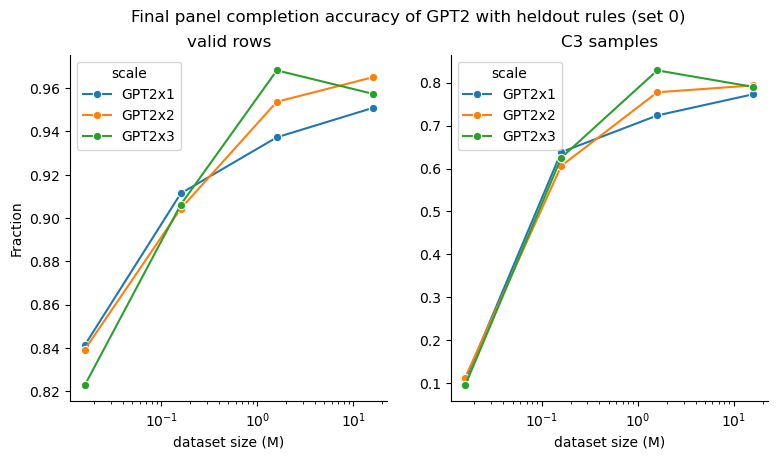

In [241]:
figh = plot_data_scaling_curve_syndf(syndf_GPT_sel, syndf_GPT_sel.heldout==True, yvars=["Val/AnyValid", "Val/C3"], huevar="scale", hue_order=["GPT2x1", "GPT2x2", "GPT2x3"])
figh.suptitle("Final panel completion accuracy of GPT2 with heldout rules (set 0)")
saveallforms(figdir, "GPT2_heldout0_data_model_scale_cmp_curve_panelcompl", figh)
plt.show()

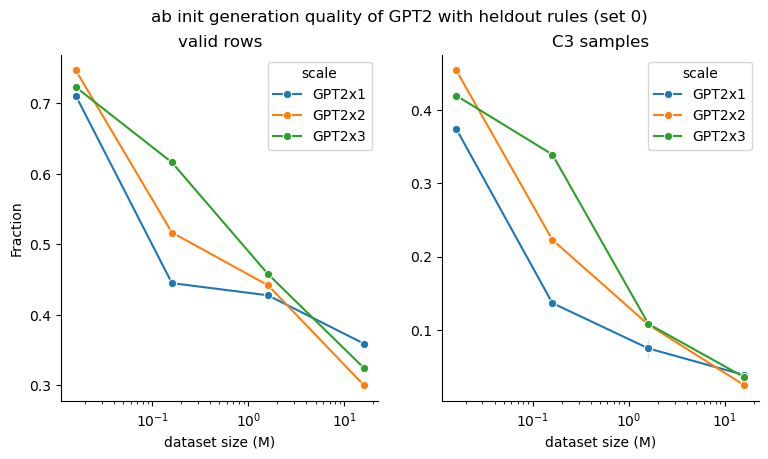

In [242]:
plot_data_scaling_curve_syndf(syndf_GPT_sel, syndf_GPT_sel.heldout==True, yvars=["Val/AnyValid_abinit", "Val/C3_abinit"], huevar="scale", hue_order=["GPT2x1", "GPT2x2", "GPT2x3"])
plt.suptitle("ab init generation quality of GPT2 with heldout rules (set 0)")
saveallforms(figdir, "GPT2_heldout0_data_model_scale_cmp_curve_abinit_gen", figh)
plt.show()

### Plot learning curve cmp

In [246]:
sorted(syndf_GPT_sel.full_name.unique().tolist())

['GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs',
 'GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs',
 'GPT2_base_RAVEN_uncond_heldout0_stream16M-20240820-024031/tensorboard_logs',
 'GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240820-023925/tensorboard_logs',
 'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs',
 'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs',
 'GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs',
 'GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240820-023917/tensorboard_logs',
 'GPT2_small_RAVEN_uncond_heldout0_stream0_016M-20240820-024539/tensorboard_logs',
 'GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs',
 'GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs',
 'GPT2_small_RAVEN_uncond_heldout0_stream1_6M-20240818-013943/tensorboard_logs',
 'GPT2_small_RAVEN_unc

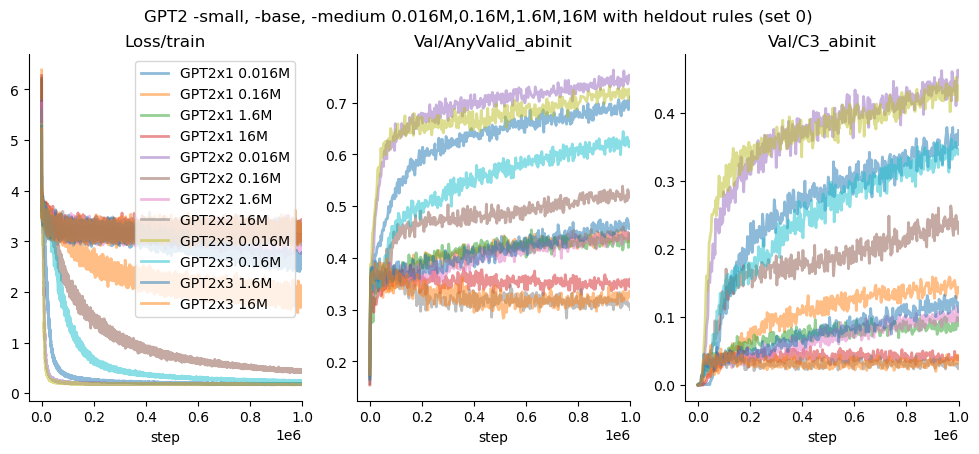

In [250]:
# Example usage:
varnames = ["Loss/train", "Val/AnyValid_abinit", "Val/C3_abinit"] # Val/Avg_Loss
runs = [
        'GPT2_small_RAVEN_uncond_heldout0_stream0_016M-20240820-024539/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream1_6M-20240818-013943/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240820-023925/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream16M-20240820-024031/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240820-023917/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs',
        ]
labels = [
        "GPT2x1 0.016M",
        "GPT2x1 0.16M",
        "GPT2x1 1.6M",
        "GPT2x1 16M",
        "GPT2x2 0.016M",
        "GPT2x2 0.16M",
        "GPT2x2 1.6M",
        "GPT2x2 16M",
        "GPT2x3 0.016M",
        "GPT2x3 0.16M",
        "GPT2x3 1.6M",
        "GPT2x3 16M",
        ]
        
figh = plot_learning_curve_cmp(tb_data_col_GPT, varnames, runs, labels, xlim=10E5);
figh.suptitle("GPT2 -small, -base, -medium 0.016M,0.16M,1.6M,16M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "GPT2-S-B-M_0.016M-16M_all_heldout0_cmp_curve", figh)

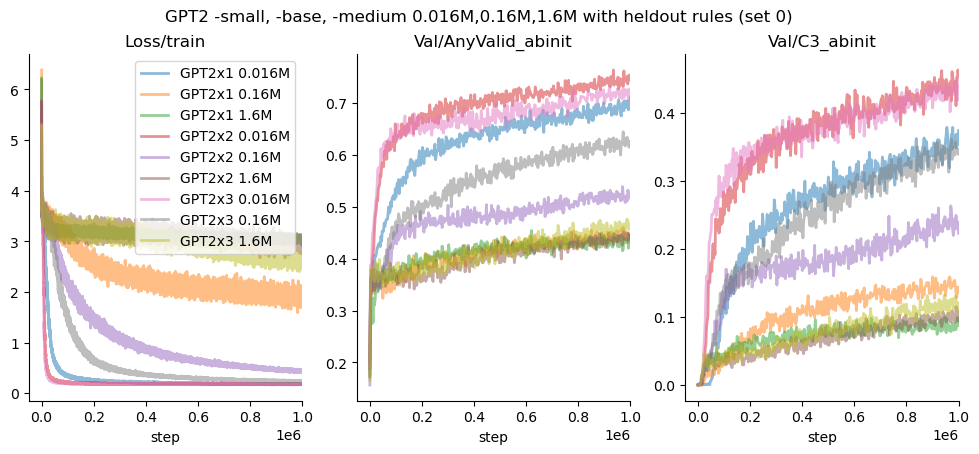

In [251]:
# Example usage:
varnames = ["Loss/train", "Val/AnyValid_abinit", "Val/C3_abinit"] # Val/Avg_Loss
runs = [
        'GPT2_small_RAVEN_uncond_heldout0_stream0_016M-20240820-024539/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream1_6M-20240818-013943/tensorboard_logs',
        # 'GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240820-023925/tensorboard_logs',
        # 'GPT2_base_RAVEN_uncond_heldout0_stream16M-20240820-024031/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240820-023917/tensorboard_logs',
        # 'GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs',
        ]
labels = [
        "GPT2x1 0.016M",
        "GPT2x1 0.16M",
        "GPT2x1 1.6M",
        # "GPT2x1 16M",
        "GPT2x2 0.016M",
        "GPT2x2 0.16M",
        "GPT2x2 1.6M",
        # "GPT2x2 16M",
        "GPT2x3 0.016M",
        "GPT2x3 0.16M",
        "GPT2x3 1.6M",
        # "GPT2x3 16M",
        ]
        
figh = plot_learning_curve_cmp(tb_data_col_GPT, varnames, runs, labels, xlim=10E5);
figh.suptitle("GPT2 -small, -base, -medium 0.016M,0.16M,1.6M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "GPT2-S-B-M_0.016M-1.6M_all_heldout0_cmp_curve", figh)

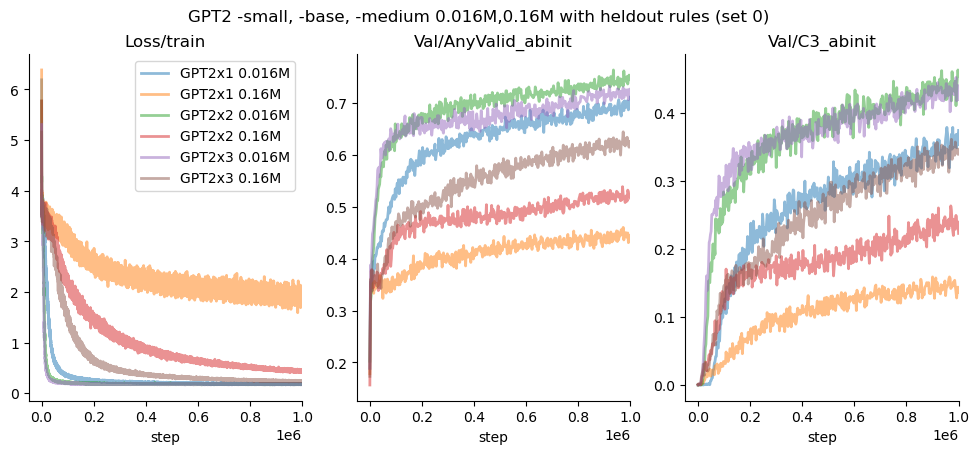

In [252]:
# Example usage:
varnames = ["Loss/train", "Val/AnyValid_abinit", "Val/C3_abinit"] # Val/Avg_Loss
runs = [
        'GPT2_small_RAVEN_uncond_heldout0_stream0_016M-20240820-024539/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs',
        # 'GPT2_small_RAVEN_uncond_heldout0_stream1_6M-20240818-013943/tensorboard_logs',
        # 'GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs',
        # 'GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240820-023925/tensorboard_logs',
        # 'GPT2_base_RAVEN_uncond_heldout0_stream16M-20240820-024031/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs',
        # 'GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240820-023917/tensorboard_logs',
        # 'GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs',
        ]
labels = [
        "GPT2x1 0.016M",
        "GPT2x1 0.16M",
        # "GPT2x1 1.6M",
        # "GPT2x1 16M",
        "GPT2x2 0.016M",
        "GPT2x2 0.16M",
        # "GPT2x2 1.6M",
        # "GPT2x2 16M",
        "GPT2x3 0.016M",
        "GPT2x3 0.16M",
        # "GPT2x3 1.6M",
        # "GPT2x3 16M",
        ]
        
figh = plot_learning_curve_cmp(tb_data_col_GPT, varnames, runs, labels, xlim=10E5);
figh.suptitle("GPT2 -small, -base, -medium 0.016M,0.16M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "GPT2-S-B-M_0.016M-0.16M_all_heldout0_cmp_curve", figh)

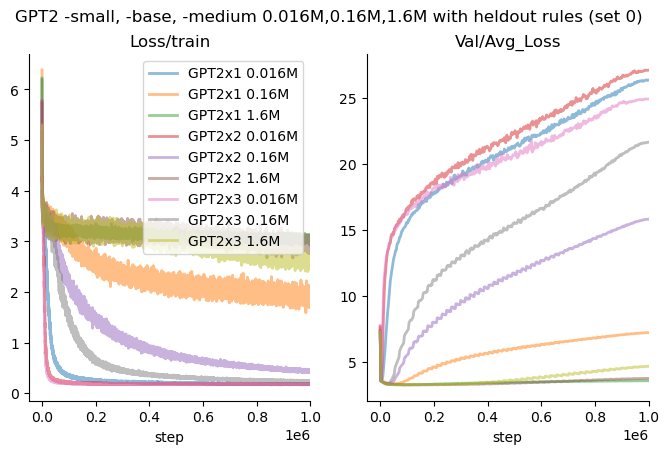

In [255]:
# Example usage:
varnames = ["Loss/train", "Val/Avg_Loss"] # Val/Avg_Loss
runs = [
        'GPT2_small_RAVEN_uncond_heldout0_stream0_016M-20240820-024539/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream1_6M-20240818-013943/tensorboard_logs',
        # 'GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240820-023925/tensorboard_logs',
        # 'GPT2_base_RAVEN_uncond_heldout0_stream16M-20240820-024031/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240820-023917/tensorboard_logs',
        # 'GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs',
        ]
labels = [
        "GPT2x1 0.016M",
        "GPT2x1 0.16M",
        "GPT2x1 1.6M",
        # "GPT2x1 16M",
        "GPT2x2 0.016M",
        "GPT2x2 0.16M",
        "GPT2x2 1.6M",
        # "GPT2x2 16M",
        "GPT2x3 0.016M",
        "GPT2x3 0.16M",
        "GPT2x3 1.6M",
        # "GPT2x3 16M",
        ]
        
figh = plot_learning_curve_cmp(tb_data_col_GPT, varnames, runs, labels, xlim=10E5);
figh.suptitle("GPT2 -small, -base, -medium 0.016M,0.16M,1.6M with heldout rules (set 0)")
figh.show()
saveallforms(figdir, "GPT2-S-B-M_0.016M-1.6M_all_heldout0_cmp_train_val_loss_curve", figh)

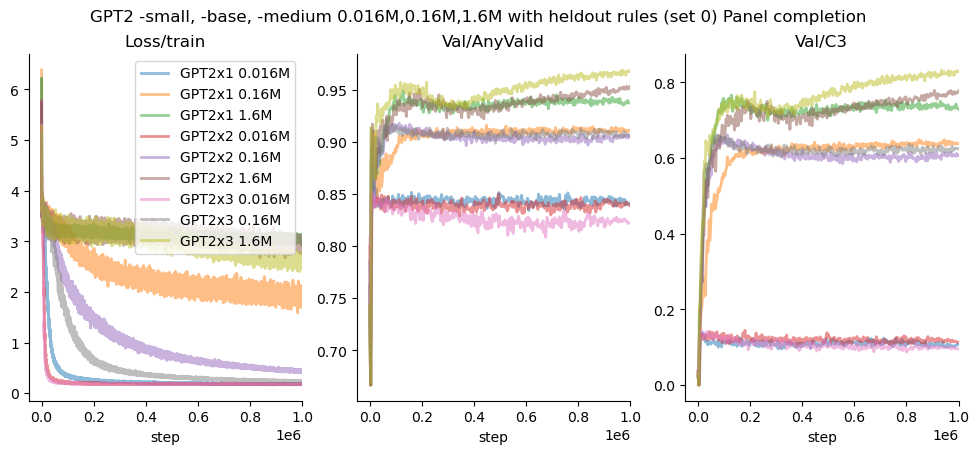

In [254]:
# Example usage:
varnames = ["Loss/train", "Val/AnyValid", "Val/C3"] # Val/Avg_Loss
runs = [
        'GPT2_small_RAVEN_uncond_heldout0_stream0_016M-20240820-024539/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream1_6M-20240818-013943/tensorboard_logs',
        # 'GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240820-023925/tensorboard_logs',
        # 'GPT2_base_RAVEN_uncond_heldout0_stream16M-20240820-024031/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240820-023917/tensorboard_logs',
        # 'GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs',
        ]
labels = [
        "GPT2x1 0.016M",
        "GPT2x1 0.16M",
        "GPT2x1 1.6M",
        # "GPT2x1 16M",
        "GPT2x2 0.016M",
        "GPT2x2 0.16M",
        "GPT2x2 1.6M",
        # "GPT2x2 16M",
        "GPT2x3 0.016M",
        "GPT2x3 0.16M",
        "GPT2x3 1.6M",
        # "GPT2x3 16M",
        ]
        
figh = plot_learning_curve_cmp(tb_data_col_GPT, varnames, runs, labels, xlim=10E5);
figh.suptitle("GPT2 -small, -base, -medium 0.016M,0.16M,1.6M with heldout rules (set 0) Panel completion")
figh.show()
saveallforms(figdir, "GPT2-S-B-M_0.016M-1.6M_all_heldout0_cmp_curve_panelcompl", figh)

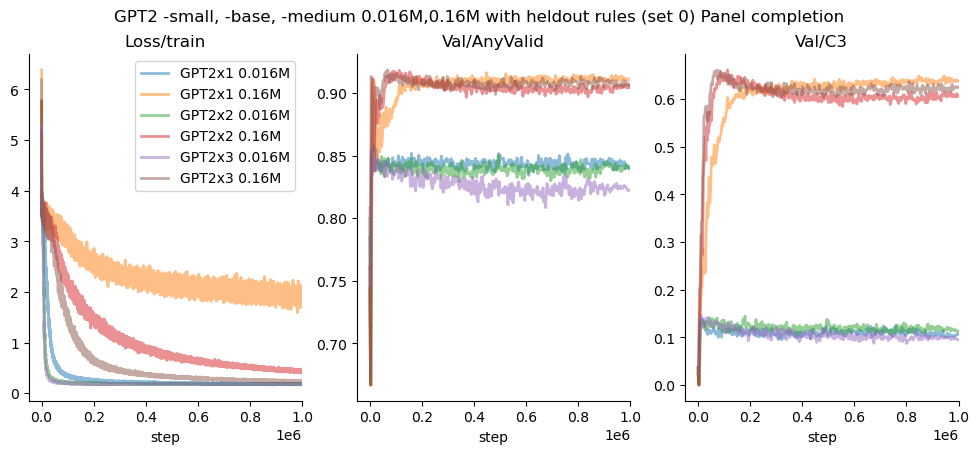

In [253]:
# Example usage:
varnames = ["Loss/train", "Val/AnyValid", "Val/C3"] # Val/Avg_Loss
runs = [
        'GPT2_small_RAVEN_uncond_heldout0_stream0_016M-20240820-024539/tensorboard_logs',
        'GPT2_small_RAVEN_uncond_heldout0_stream0_16M-20240820-024128/tensorboard_logs',
        # 'GPT2_small_RAVEN_uncond_heldout0_stream1_6M-20240818-013943/tensorboard_logs',
        # 'GPT2_small_RAVEN_uncond_heldout0_stream16M-20240820-024127/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_016M-20240820-023934/tensorboard_logs',
        'GPT2_base_RAVEN_uncond_heldout0_stream0_16M-20240820-024013/tensorboard_logs',
        # 'GPT2_base_RAVEN_uncond_heldout0_stream1_6M-20240820-023925/tensorboard_logs',
        # 'GPT2_base_RAVEN_uncond_heldout0_stream16M-20240820-024031/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_016M-20240820-024735/tensorboard_logs',
        'GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs',
        # 'GPT2_medium_RAVEN_uncond_heldout0_stream1_6M-20240820-023917/tensorboard_logs',
        # 'GPT2_medium_RAVEN_uncond_heldout0_stream16M-20240820-024718/tensorboard_logs',
        ]
labels = [
        "GPT2x1 0.016M",
        "GPT2x1 0.16M",
        # "GPT2x1 1.6M",
        # "GPT2x1 16M",
        "GPT2x2 0.016M",
        "GPT2x2 0.16M",
        # "GPT2x2 1.6M",
        # "GPT2x2 16M",
        "GPT2x3 0.016M",
        "GPT2x3 0.16M",
        # "GPT2x3 1.6M",
        # "GPT2x3 16M",
        ]
        
figh = plot_learning_curve_cmp(tb_data_col_GPT, varnames, runs, labels, xlim=10E5);
figh.suptitle("GPT2 -small, -base, -medium 0.016M,0.16M with heldout rules (set 0) Panel completion")
figh.show()
saveallforms(figdir, "GPT2-S-B-M_0.016M-0.16M_all_heldout0_cmp_curve_panelcompl", figh)